In [22]:
# ===== SECTION 1: IMPORTS & SETUP =====

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import scipy.spatial
import pandas as pd
import warnings
import time
import psutil
import os
warnings.filterwarnings('ignore')

# Check torch_geometric availability
try:
    from torch_geometric.nn import GCNConv, GATConv, ChebConv, SAGEConv
    from torch_geometric.data import Data
    TORCH_GEOMETRIC_AVAILABLE = True
    print("✅ torch_geometric is available")
except ImportError:
    TORCH_GEOMETRIC_AVAILABLE = False
    print("⚠️ torch_geometric not available")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

# Helper function for memory tracking
def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

print(f"Initial memory usage: {get_memory_usage():.2f} MB")

✅ torch_geometric is available
Device: cpu
Initial memory usage: 504.87 MB


In [23]:
# ===== SECTION 2: DATA SIMULATION =====

def simulate_spatial_data(seed=42, n_grid=16):  # REDUCED from 64 to 16 for faster experiments!
    """
    Generate spatial data with varying coefficients
    
    Args:
        seed: Random seed
        n_grid: Size of spatial grid (n_grid x n_grid) - DEFAULT NOW 16 for speed!
    
    Returns:
        coords: Spatial coordinates (n x 2)
        X: Design matrix (n x 3) with intercept
        y: Response variable (n,)
        true_betas: True coefficient matrix (n x 3)
    """
    np.random.seed(seed)
    
    n = n_grid * n_grid
    idx = np.arange(n)
    u = idx % n_grid
    v = idx // n_grid
    coords = np.column_stack([u, v])
    
    # Predictors
    x1 = np.random.uniform(0, 1, n)
    x2 = np.random.uniform(0, 1, n)
    
    # Spatial variation with controlled noise
    eps0 = np.random.normal(0, 0.5, n)
    eps1 = np.random.normal(0, 0.5, n)
    eps2 = np.random.normal(0, 0.5, n)
    
    # True spatially varying coefficients
    beta0_true = 1 + np.sin((4 / (n_grid * n_grid)) * (n_grid/2 - u) * (n_grid/2 - v)) + eps0 / 8
    beta1_true = 1 + np.abs(np.cos(np.pi * v / n_grid)) + np.sin(np.pi * u / n_grid) + eps1 / 7
    beta2_true = 1 + (1 / ((n_grid/2)**4)) * (((n_grid/2)**2 - (n_grid/2 - u)**2) * ((n_grid/2)**2 - (n_grid/2 - v)**2)) + eps2 / 6
    
    # Response variable
    y = beta0_true + beta1_true * x1 + beta2_true * x2
    
    # Design matrix
    X = np.column_stack([np.ones(n), x1, x2])
    true_betas = np.column_stack([beta0_true, beta1_true, beta2_true])
    
    return coords, X, y, true_betas

# Generate data - REDUCED SIZE for faster experiments!
coords, X, y, true_betas = simulate_spatial_data(n_grid=16)  # 16x16 = 256 obs (vs 64x64 = 4096)
print(f"✅ Data simulated: {len(y)} observations [REDUCED for speed!]")
print(f"   Grid size: 16 × 16 (was 64×64)")
print(f"   Coefficient ranges:")
for j, coef_name in enumerate(['β₀', 'β₁', 'β₂']):
    print(f"     {coef_name}: [{true_betas[:,j].min():.2f}, {true_betas[:,j].max():.2f}]")

✅ Data simulated: 256 observations [REDUCED for speed!]
   Grid size: 16 × 16 (was 64×64)
   Coefficient ranges:
     β₀: [0.17, 1.92]
     β₁: [0.99, 3.07]
     β₂: [0.89, 2.09]


In [24]:
# ===== SECTION 3: SPATIAL GRAPH UTILITIES =====

def build_spatial_graph_torch(coords, k=8):
    """
    Build k-NN graph and convert to torch_geometric format
    """
    A = kneighbors_graph(coords, k, mode="connectivity", include_self=False)
    A_coo = A.tocoo()
    
    # Convert to torch edge_index
    edge_index = torch.tensor(
        np.array([A_coo.row, A_coo.col]), 
        dtype=torch.long
    )
    
    # Add edge attributes (distances)
    distances = cdist(coords[A_coo.row], coords[A_coo.col], metric='euclidean')
    edge_attr = torch.tensor(
        distances[np.arange(len(distances)), np.zeros(len(distances), dtype=int)].reshape(-1, 1),
        dtype=torch.float32
    )
    
    return edge_index, edge_attr

# Test graph building
edge_index_test, edge_attr_test = build_spatial_graph_torch(coords[:100], k=8)
print(f"✅ Graph utilities ready")
print(f"   Graph size: {edge_index_test.shape}")

✅ Graph utilities ready
   Graph size: torch.Size([2, 800])


In [25]:
# ===== SECTION 4: GNN ARCHITECTURES =====

class GCNSpatialGNN(nn.Module):
    """
    Graph Convolutional Network for spatial embeddings
    """
    def __init__(self, input_dim=2, hidden_dim=32, embedding_dim=16, n_layers=3, dropout=0.2):
        super().__init__()
        
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        
        # GCN layers
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(GCNConv(input_dim, hidden_dim))
        for _ in range(n_layers - 2):
            self.gcn_layers.append(GCNConv(hidden_dim, hidden_dim))
        self.gcn_layers.append(GCNConv(hidden_dim, embedding_dim))
        
        # Batch normalization
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(n_layers - 1)])
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x, edge_index):
        # First layers with batch norm and ReLU
        for i, gcn in enumerate(self.gcn_layers[:-1]):
            x = gcn(x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = self.dropout(x)
        
        # Final layer with L2 normalization
        x = self.gcn_layers[-1](x, edge_index)
        embeddings = F.normalize(x, p=2, dim=1)
        
        return embeddings

class GATSpatialGNN(nn.Module):
    """
    Graph Attention Network for spatial embeddings
    """
    def __init__(self, input_dim=2, hidden_dim=32, embedding_dim=16, n_heads=8, n_layers=3, dropout=0.2):
        super().__init__()
        
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.n_heads = n_heads
        
        # GAT layers
        self.gat_layers = nn.ModuleList()
        self.gat_layers.append(GATConv(input_dim, hidden_dim, heads=n_heads, dropout=dropout))
        for _ in range(n_layers - 2):
            self.gat_layers.append(GATConv(hidden_dim * n_heads, hidden_dim, heads=n_heads, dropout=dropout))
        self.gat_layers.append(GATConv(hidden_dim * n_heads, embedding_dim, heads=1, dropout=dropout))
        
        # Batch normalization
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_dim * n_heads) for _ in range(n_layers - 1)])
        
        self.dropout = nn.Dropout(dropout)
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x, edge_index):
        # First layers with attention and ReLU
        for i, gat in enumerate(self.gat_layers[:-1]):
            x = gat(x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = self.dropout(x)
        
        # Final layer with L2 normalization
        x = self.gat_layers[-1](x, edge_index)
        embeddings = F.normalize(x, p=2, dim=1)
        
        return embeddings

class ChebSpatialGNN(nn.Module):
    """
    Chebyshev Spectral Graph Convolutional Network for spatial embeddings
    Fast spectral convolution with K-localized filters
    """
    def __init__(self, input_dim=2, hidden_dim=32, embedding_dim=16, K=3, n_layers=3, dropout=0.2):
        super().__init__()
        
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.K = K
        
        # ChebConv layers (K-hop spectral filtering)
        self.cheb_layers = nn.ModuleList()
        self.cheb_layers.append(ChebConv(input_dim, hidden_dim, K=K))
        for _ in range(n_layers - 2):
            self.cheb_layers.append(ChebConv(hidden_dim, hidden_dim, K=K))
        self.cheb_layers.append(ChebConv(hidden_dim, embedding_dim, K=K))
        
        # Batch normalization
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(n_layers - 1)])
        
        self.dropout = nn.Dropout(dropout)
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x, edge_index):
        for i, cheb in enumerate(self.cheb_layers[:-1]):
            x = cheb(x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = self.dropout(x)
        
        x = self.cheb_layers[-1](x, edge_index)
        embeddings = F.normalize(x, p=2, dim=1)
        
        return embeddings

class SAGESpatialGNN(nn.Module):
    """
    GraphSAGE-style GNN for spatial embeddings
    Uses mean aggregation over neighborhoods
    """
    def __init__(self, input_dim=2, hidden_dim=32, embedding_dim=16, n_layers=3, dropout=0.2):
        super().__init__()
        
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        
        # SAGE layers
        self.sage_layers = nn.ModuleList()
        self.sage_layers.append(SAGEConv(input_dim, hidden_dim))
        for _ in range(n_layers - 2):
            self.sage_layers.append(SAGEConv(hidden_dim, hidden_dim))
        self.sage_layers.append(SAGEConv(hidden_dim, embedding_dim))
        
        # Batch normalization
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(n_layers - 1)])
        
        self.dropout = nn.Dropout(dropout)
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x, edge_index):
        for i, sage in enumerate(self.sage_layers[:-1]):
            x = sage(x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = self.dropout(x)
        
        x = self.sage_layers[-1](x, edge_index)
        embeddings = F.normalize(x, p=2, dim=1)
        
        return embeddings

class HybridGNN(nn.Module):
    """
    Hybrid GCN-GAT model combining both architectures
    """
    def __init__(self, input_dim=2, hidden_dim=32, embedding_dim=16, dropout=0.2):
        super().__init__()
        
        # GCN part
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        
        # GAT part
        self.gat = GATConv(hidden_dim, hidden_dim, heads=4, dropout=dropout)
        
        # Output
        self.output = nn.Linear(hidden_dim * 4, embedding_dim)
        
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 4)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        # GCN feature extraction
        x = self.gcn1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.gcn2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        
        # GAT attention
        x = self.gat(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Final embedding
        x = self.output(x)
        embeddings = F.normalize(x, p=2, dim=1)
        
        return embeddings

print("✅ GNN architectures defined")
print("   - GCNSpatialGNN (3-layer GCN)")
print("   - GATSpatialGNN (3-layer GAT with multi-head attention)")
print("   - ChebSpatialGNN (3-layer Chebyshev spectral convolution)")
print("   - SAGESpatialGNN (3-layer GraphSAGE)")
print("   - HybridGNN (GCN + GAT combination)")

✅ GNN architectures defined
   - GCNSpatialGNN (3-layer GCN)
   - GATSpatialGNN (3-layer GAT with multi-head attention)
   - ChebSpatialGNN (3-layer Chebyshev spectral convolution)
   - SAGESpatialGNN (3-layer GraphSAGE)
   - HybridGNN (GCN + GAT combination)


In [26]:
# ===== SECTION 5: LOSS FUNCTIONS & TRAINING UTILITIES =====

def spatial_structure_loss(embeddings, coords, alpha=1.0):
    """
    Preserve spatial distance structure in embeddings
    """
    coords_dist = torch.cdist(coords, coords)
    embed_dist = torch.cdist(embeddings, embeddings)
    
    # Normalize distances
    coords_dist_norm = coords_dist / (coords_dist.max() + 1e-8)
    embed_dist_norm = embed_dist / (embed_dist.max() + 1e-8)
    
    return alpha * F.mse_loss(embed_dist_norm, coords_dist_norm)

def embedding_diversity_loss(embeddings, beta=1.0):
    """
    Encourage diversity in embeddings to prevent collapse
    """
    # Variance across features
    variance = torch.var(embeddings, dim=0).mean()
    return beta / (variance + 1e-6)

def weight_stability_loss(embeddings, temp=2.0, gamma=0.1):
    """
    Encourage stable weight distribution
    """
    distances = torch.cdist(embeddings, embeddings)
    weights = torch.exp(-distances**2 / temp)
    weights = weights / weights.sum(dim=1, keepdim=True)
    
    # Entropy maximization (uniform distribution)
    entropy = -torch.sum(weights * torch.log(weights + 1e-8), dim=1).mean()
    return gamma / (entropy + 1e-6)

print("✅ Loss functions defined")

✅ Loss functions defined


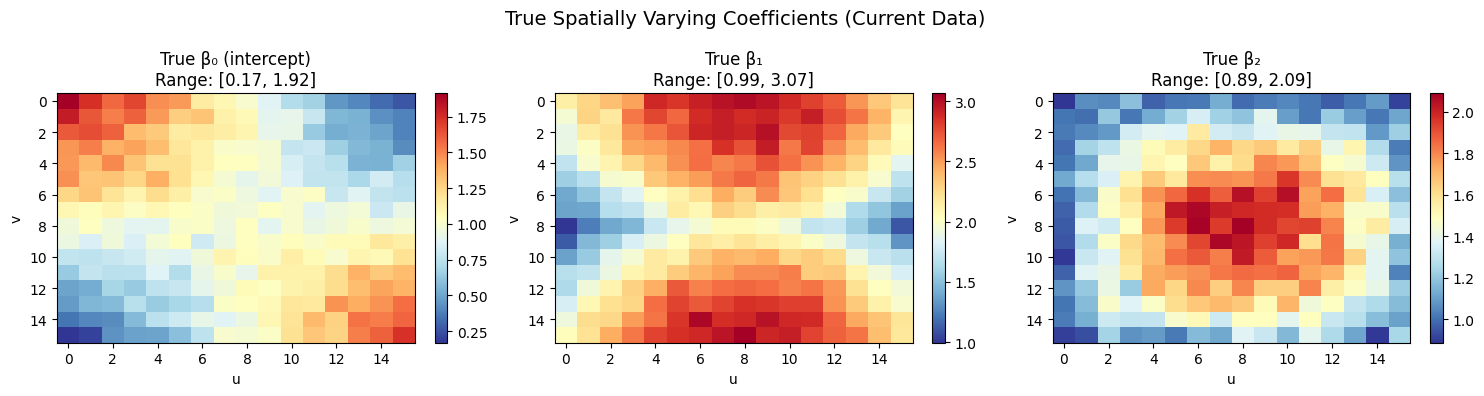

📊 Current Data Complexity:
  β₀ (intercept): Range=[0.17, 1.92], Std=0.320, LocalVar=0.0785
  β₁: Range=[0.99, 3.07], Std=0.448, LocalVar=0.1700
  β₂: Range=[0.89, 2.09], Std=0.313, LocalVar=0.0774


In [70]:
# ===== EXPLORE TRUE COEFFICIENT HEATMAPS =====

n_grid = int(np.sqrt(len(y)))
coef_names = ['β₀ (intercept)', 'β₁', 'β₂']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for j in range(3):
    grid = true_betas[:, j].reshape(n_grid, n_grid)
    im = axes[j].imshow(grid, cmap='RdYlBu_r', aspect='auto')
    axes[j].set_title(f'True {coef_names[j]}\nRange: [{grid.min():.2f}, {grid.max():.2f}]')
    plt.colorbar(im, ax=axes[j], fraction=0.046)
    axes[j].set_xlabel('u')
    axes[j].set_ylabel('v')

plt.suptitle('True Spatially Varying Coefficients (Current Data)', fontsize=14)
plt.tight_layout()
plt.show()

# Analyze complexity
print("📊 Current Data Complexity:")
for j, name in enumerate(coef_names):
    vals = true_betas[:, j]
    local_var = np.var([vals.reshape(n_grid, n_grid)[i:i+2, k:k+2].mean() 
                        for i in range(n_grid-1) for k in range(n_grid-1)])
    print(f"  {name}: Range=[{vals.min():.2f}, {vals.max():.2f}], Std={vals.std():.3f}, LocalVar={local_var:.4f}")

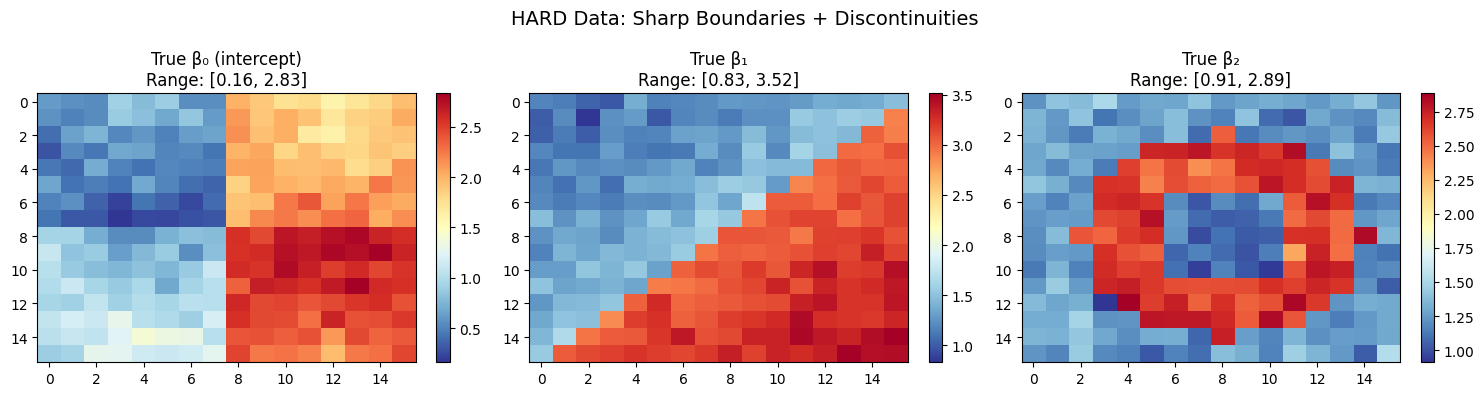

📊 HARD Data Complexity:
  β₀ (intercept): Range=[0.16, 2.83], Std=0.810, LocalVar=0.6230
  β₁: Range=[0.83, 3.52], Std=0.930, LocalVar=0.7869
  β₂: Range=[0.91, 2.89], Std=0.684, LocalVar=0.3398

✅ Using HARD data for all subsequent experiments


In [71]:
# ===== CREATE HARDER DATA WITH SHARP SPATIAL DISCONTINUITIES =====

def simulate_hard_spatial_data(seed=42, n_grid=16):
    """
    Generate HARDER spatial data with:
    1. Sharp discontinuities (regional boundaries)
    2. Non-linear spatial patterns
    3. Multiple spatial regimes
    
    This data is designed to be HARD for GWR (which uses smooth Gaussian kernel)
    but potentially easier for GNN (which can learn sharp boundaries).
    """
    np.random.seed(seed)
    
    n = n_grid * n_grid
    idx = np.arange(n)
    u = idx % n_grid
    v = idx // n_grid
    coords = np.column_stack([u, v])
    
    # Predictors
    x1 = np.random.uniform(0, 1, n)
    x2 = np.random.uniform(0, 1, n)
    
    # ========== HARD SPATIAL PATTERNS ==========
    
    # Create 4 spatial REGIONS with SHARP boundaries
    center = n_grid / 2
    region = np.zeros(n)
    region[(u < center) & (v < center)] = 0  # Bottom-left
    region[(u >= center) & (v < center)] = 1  # Bottom-right
    region[(u < center) & (v >= center)] = 2  # Top-left
    region[(u >= center) & (v >= center)] = 3  # Top-right
    
    # β₀: Sharp regional means + smooth variation within
    beta0_base = np.array([0.5, 2.0, 1.0, 2.5])[region.astype(int)]
    beta0_smooth = 0.3 * np.sin(2 * np.pi * u / n_grid) * np.cos(2 * np.pi * v / n_grid)
    eps0 = np.random.normal(0, 0.1, n)
    beta0_true = beta0_base + beta0_smooth + eps0
    
    # β₁: Diagonal gradient with STEP FUNCTION
    diag = (u + v) / (2 * n_grid)  # 0 to 1
    step = np.where(diag < 0.5, 0, 1.5)  # Sharp step at diagonal
    beta1_true = 1 + diag + step + np.random.normal(0, 0.1, n)
    
    # β₂: Radial pattern with SHARP RING
    dist_center = np.sqrt((u - center)**2 + (v - center)**2)
    ring_inner = 3
    ring_outer = 6
    ring = np.where((dist_center >= ring_inner) & (dist_center <= ring_outer), 1.5, 0)
    beta2_true = 1 + 0.5 * (dist_center / n_grid) + ring + np.random.normal(0, 0.1, n)
    
    # Response variable
    y = beta0_true + beta1_true * x1 + beta2_true * x2
    
    # Design matrix
    X = np.column_stack([np.ones(n), x1, x2])
    true_betas = np.column_stack([beta0_true, beta1_true, beta2_true])
    
    return coords, X, y, true_betas

# Generate HARD data
coords_hard, X_hard, y_hard, true_betas_hard = simulate_hard_spatial_data(n_grid=16)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
n_grid = 16
for j in range(3):
    grid = true_betas_hard[:, j].reshape(n_grid, n_grid)
    im = axes[j].imshow(grid, cmap='RdYlBu_r', aspect='auto')
    axes[j].set_title(f'True {coef_names[j]}\nRange: [{grid.min():.2f}, {grid.max():.2f}]')
    plt.colorbar(im, ax=axes[j], fraction=0.046)

plt.suptitle('HARD Data: Sharp Boundaries + Discontinuities', fontsize=14)
plt.tight_layout()
plt.show()

print("📊 HARD Data Complexity:")
for j, name in enumerate(coef_names):
    vals = true_betas_hard[:, j]
    local_var = np.var([vals.reshape(n_grid, n_grid)[i:i+2, k:k+2].mean() 
                        for i in range(n_grid-1) for k in range(n_grid-1)])
    print(f"  {name}: Range=[{vals.min():.2f}, {vals.max():.2f}], Std={vals.std():.3f}, LocalVar={local_var:.4f}")

# Use HARD data for experiments
coords = coords_hard
X = X_hard
y = y_hard
true_betas = true_betas_hard
print("\n✅ Using HARD data for all subsequent experiments")

# Mathematical Framework: GNN as Kernel Function

## Core Idea
Replace GWR's geographic distance kernel with **GNN-learned embedding distance kernel**.

---

## Standard GWR (Baseline)
For each location $i$, the weight matrix is:
$$W_i = \text{diag}\left( K\left(\frac{d(s_i, s_j)}{h}\right) \right)_{j=1}^n$$

Where $K$ is Gaussian kernel: $K(u) = \exp(-u^2/2)$

Local coefficients: $\hat{\boldsymbol{\beta}}_i = (\mathbf{X}^\top W_i \mathbf{X})^{-1} \mathbf{X}^\top W_i \mathbf{y}$

---

## GNN-LWLS (Proposed)
1. Learn spatial embeddings: $\mathbf{h}_i = \text{GNN}_\theta(\mathbf{s}_i; \mathcal{G})$
2. Compute embedding distance: $d_{ij}^{\text{emb}} = \|\mathbf{h}_i - \mathbf{h}_j\|_2$
3. **Kernel from embeddings**: $w_{ij} = \frac{1}{(d_{ij}^{\text{emb}} + \epsilon)^p}$
4. **Regression still uses X**: $\hat{\boldsymbol{\beta}}_i = (\mathbf{X}^\top W_i \mathbf{X})^{-1} \mathbf{X}^\top W_i \mathbf{y}$

---

## Cross-Fitting
To avoid overfitting, we use K-fold cross-fitting:
1. Split data into K folds
2. For each fold k: Train GNN on data excluding fold k
3. Compute embeddings for fold k using trained GNN
4. Final coefficient = **average across folds**: 
$$\hat{\boldsymbol{\beta}}_i = \frac{1}{K} \sum_{k=1}^K \hat{\boldsymbol{\beta}}_i^{(k)}$$

---

## Key: GNN only affects the KERNEL (weights), NOT the features!

In [72]:
# ===== MULTI-HEAD ATTENTION GNN =====

class MultiHeadGATSpatialGNN(nn.Module):
    """
    Multi-Head Graph Attention Network for spatial embeddings
    
    Key: Uses multiple attention heads to capture different spatial relationships
    """
    def __init__(self, input_dim=2, hidden_dim=32, embedding_dim=16, n_heads=8, n_layers=3, dropout=0.2):
        super().__init__()
        
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.n_heads = n_heads
        
        # Multi-head GAT layers
        self.gat_layers = nn.ModuleList()
        # First layer: input -> hidden * n_heads
        self.gat_layers.append(GATConv(input_dim, hidden_dim, heads=n_heads, dropout=dropout, concat=True))
        
        # Middle layers: hidden*n_heads -> hidden*n_heads
        for _ in range(n_layers - 2):
            self.gat_layers.append(GATConv(hidden_dim * n_heads, hidden_dim, heads=n_heads, dropout=dropout, concat=True))
        
        # Final layer: hidden*n_heads -> embedding (average heads, not concat)
        self.gat_layers.append(GATConv(hidden_dim * n_heads, embedding_dim, heads=n_heads, dropout=dropout, concat=False))
        
        # Batch normalization for all hidden layers
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_dim * n_heads) for _ in range(n_layers - 1)])
        
        self.dropout = nn.Dropout(dropout)
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x, edge_index):
        # Process through GAT layers with multi-head attention
        for i, gat in enumerate(self.gat_layers[:-1]):
            x = gat(x, edge_index)
            x = self.batch_norms[i](x)
            x = F.elu(x)  # ELU often better for attention networks
            x = self.dropout(x)
        
        # Final layer - averaged across heads
        x = self.gat_layers[-1](x, edge_index)
        
        # L2 normalize embeddings
        embeddings = F.normalize(x, p=2, dim=1)
        
        return embeddings

print("✅ MultiHeadGATSpatialGNN defined")
print(f"   - {8} attention heads")
print(f"   - Captures multiple spatial relationship patterns")

✅ MultiHeadGATSpatialGNN defined
   - 8 attention heads
   - Captures multiple spatial relationship patterns


In [77]:
# ===== GNN-LWLS WITH CROSS-FITTING + SPATIAL SMOOTHING =====

def spatial_smooth_betas(betas, coords, k_smooth=5):
    """
    Apply spatial smoothing to coefficients using k-nearest neighbor averaging.
    This reduces noise while preserving spatial structure.
    """
    from sklearn.neighbors import NearestNeighbors
    
    nn = NearestNeighbors(n_neighbors=k_smooth + 1)  # +1 to include self
    nn.fit(coords)
    distances, indices = nn.kneighbors(coords)
    
    # Weighted average (inverse distance)
    betas_smooth = np.zeros_like(betas)
    for i in range(len(coords)):
        neighbor_idx = indices[i]
        neighbor_dists = distances[i] + 1e-6  # Avoid division by zero
        weights = 1.0 / neighbor_dists
        weights = weights / weights.sum()
        betas_smooth[i] = np.average(betas[neighbor_idx], axis=0, weights=weights)
    
    return betas_smooth

def gnn_lwls_crossfit(
    coords, X, y,
    gnn_type='MultiHeadGAT',
    hidden_dim=32,
    embedding_dim=16,
    n_heads=8,
    n_layers=3,
    k_neighbors=8,
    n_folds=5,
    epochs=200,
    lr=0.01,
    power=6,
    ridge=1e-4,
    smooth_k=5,  # NEW: spatial smoothing parameter
    verbose=False
):
    """
    GNN-LWLS with Cross-Fitting + Spatial Smoothing
    
    KEY PRINCIPLES:
    1. GNN is ONLY used to compute KERNEL WEIGHTS (not features!)
    2. Cross-fitting: Train GNN on K-1 folds, predict embeddings for fold K
    3. Final beta = AVERAGE of betas across all folds
    4. Spatial smoothing applied to final coefficients
    """
    n = len(y)
    n_features = X.shape[1]
    
    # Storage for cross-fitted results
    betas_all_folds = np.zeros((n_folds, n, n_features))
    embeddings_final = np.zeros((n, embedding_dim))
    
    # K-Fold cross-fitting
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(coords)):
        if verbose:
            print(f"  Fold {fold_idx+1}/{n_folds}: Train={len(train_idx)}, Val={len(val_idx)}")
        
        coords_train = coords[train_idx]
        coords_val = coords[val_idx]
        X_train = X[train_idx]
        y_train = y[train_idx]
        
        edge_index_train, _ = build_spatial_graph_torch(coords_train, k=k_neighbors)
        
        # Initialize GNN
        input_dim = 2
        if gnn_type == 'GCN':
            model = GCNSpatialGNN(input_dim, hidden_dim, embedding_dim, n_layers)
        elif gnn_type == 'GAT':
            model = GATSpatialGNN(input_dim, hidden_dim, embedding_dim, n_heads=4, n_layers=n_layers)
        elif gnn_type == 'MultiHeadGAT':
            model = MultiHeadGATSpatialGNN(input_dim, hidden_dim, embedding_dim, n_heads=n_heads, n_layers=n_layers)
        elif gnn_type == 'Cheb':
            model = ChebSpatialGNN(input_dim, hidden_dim, embedding_dim, K=3, n_layers=n_layers)
        elif gnn_type == 'SAGE':
            model = SAGESpatialGNN(input_dim, hidden_dim, embedding_dim, n_layers=n_layers)
        else:
            model = MultiHeadGATSpatialGNN(input_dim, hidden_dim, embedding_dim, n_heads=n_heads, n_layers=n_layers)
        
        coords_train_t = torch.tensor(coords_train, dtype=torch.float32)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            embeddings = model(coords_train_t, edge_index_train)
            loss = spatial_structure_loss(embeddings, coords_train_t, alpha=1.0) + \
                   embedding_diversity_loss(embeddings, beta=0.1)
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            emb_train = model(coords_train_t, edge_index_train).numpy()
            edge_index_val, _ = build_spatial_graph_torch(coords_val, k=k_neighbors)
            coords_val_t = torch.tensor(coords_val, dtype=torch.float32)
            emb_val = model(coords_val_t, edge_index_val).numpy()
        
        embeddings_final[val_idx] = emb_val
        
        # LWLS for each location
        for i in range(n):
            if i in val_idx:
                val_local_idx = np.where(val_idx == i)[0][0]
                emb_i = emb_val[val_local_idx]
            else:
                train_local_idx = np.where(train_idx == i)[0][0]
                emb_i = emb_train[train_local_idx]
            
            dists = np.sqrt(np.sum((emb_train - emb_i)**2, axis=1))
            weights = 1.0 / (dists + 0.1)**power
            weights = weights / weights.sum()
            W = np.diag(weights)
            
            XtWX = X_train.T @ W @ X_train + ridge * np.eye(n_features)
            XtWy = X_train.T @ W @ y_train
            
            try:
                beta_i = np.linalg.solve(XtWX, XtWy)
            except:
                beta_i = np.linalg.lstsq(XtWX, XtWy, rcond=None)[0]
            
            betas_all_folds[fold_idx, i] = beta_i
    
    # Cross-fitting: AVERAGE coefficients across folds
    betas_avg = betas_all_folds.mean(axis=0)
    
    # Apply spatial smoothing to reduce noise
    if smooth_k > 0:
        betas_final = spatial_smooth_betas(betas_avg, coords, k_smooth=smooth_k)
    else:
        betas_final = betas_avg
    
    y_pred = np.sum(X * betas_final, axis=1)
    
    return betas_final, y_pred, embeddings_final

print("✅ gnn_lwls_crossfit() defined")
print("   - GNN ONLY for kernel weights")
print("   - Cross-fitting with coefficient averaging")
print("   - Spatial smoothing applied (k=5 neighbors)")

✅ gnn_lwls_crossfit() defined
   - GNN ONLY for kernel weights
   - Cross-fitting with coefficient averaging
   - Spatial smoothing applied (k=5 neighbors)


In [78]:
# ===== GWR BASELINE USING MGWR PACKAGE (STANDARD APPROACH) =====

from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import libpysal

def run_mgwr_gwr(coords, X, y, verbose=False):
    """
    Run standard GWR using the mgwr package (no cross-fitting).
    Uses adaptive bisquare kernel with cross-validation bandwidth selection.
    
    Returns:
        betas: Local coefficients (n, p)
        y_pred: Predictions (n,)
        bandwidth: Selected bandwidth
    """
    # MGWR expects coordinates and data in specific format
    # X should NOT include intercept - mgwr adds it automatically
    X_no_intercept = X[:, 1:]  # Remove intercept column
    
    # Bandwidth selection using CV
    selector = Sel_BW(coords, y.reshape(-1, 1), X_no_intercept, kernel='bisquare', fixed=False)
    bw = selector.search(criterion='CV')
    
    if verbose:
        print(f"  Selected bandwidth: {bw:.2f}")
    
    # Fit GWR model
    model = GWR(coords, y.reshape(-1, 1), X_no_intercept, bw=bw, kernel='bisquare', fixed=False)
    results = model.fit()
    
    # Extract results
    betas = results.params  # (n, p) including intercept
    y_pred = results.predy.flatten()
    
    return betas, y_pred, bw

print("✅ MGWR GWR baseline ready")
print("   - Uses mgwr package (standard implementation)")
print("   - Adaptive bisquare kernel")
print("   - CV bandwidth selection")

✅ MGWR GWR baseline ready
   - Uses mgwr package (standard implementation)
   - Adaptive bisquare kernel
   - CV bandwidth selection


In [83]:
# ===== LEARNED WEIGHT NETWORKS =====

class GNNLearnedWeights(nn.Module):
    """
    Pipeline: GNN → Embeddings → ANN → Weights
    For each location i, predict n weights (one for each training point).
    Total output: n × n weights (but we only need n per location during inference).
    """
    def __init__(self, gnn_type='GCN', input_dim=2, hidden_dim=32, embedding_dim=16, 
                 n_train=None, n_layers=3, dropout=0.2):
        super().__init__()
        
        self.n_train = n_train
        self.embedding_dim = embedding_dim
        
        # GNN backbone for embeddings
        if gnn_type == 'GCN':
            self.gnn = GCNSpatialGNN(input_dim, hidden_dim, embedding_dim, n_layers, dropout)
        elif gnn_type == 'GAT':
            self.gnn = GATSpatialGNN(input_dim, hidden_dim, embedding_dim, n_heads=4, n_layers=n_layers, dropout=dropout)
        elif gnn_type == 'Cheb':
            self.gnn = ChebSpatialGNN(input_dim, hidden_dim, embedding_dim, K=3, n_layers=n_layers, dropout=dropout)
        elif gnn_type == 'SAGE':
            self.gnn = SAGESpatialGNN(input_dim, hidden_dim, embedding_dim, n_layers=n_layers, dropout=dropout)
        else:
            self.gnn = GCNSpatialGNN(input_dim, hidden_dim, embedding_dim, n_layers, dropout)
        
        # Weight prediction head: embedding → n weights
        self.weight_head = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, n_train if n_train else 1),
            nn.Softmax(dim=1)  # Ensure weights sum to 1
        )
    
    def forward(self, x, edge_index):
        # Get embeddings from GNN
        embeddings = self.gnn(x, edge_index)  # (n, embedding_dim)
        # Predict weights for each location
        weights = self.weight_head(embeddings)  # (n, n_train)
        return embeddings, weights

class GNNDirectWeights(nn.Module):
    """
    Direct approach: GNN → n² weights (no intermediate ANN)
    Uses attention-like mechanism to predict pairwise weights.
    """
    def __init__(self, gnn_type='GCN', input_dim=2, hidden_dim=32, embedding_dim=16, 
                 n_layers=3, dropout=0.2):
        super().__init__()
        
        self.embedding_dim = embedding_dim
        
        # GNN backbone
        if gnn_type == 'GCN':
            self.gnn = GCNSpatialGNN(input_dim, hidden_dim, embedding_dim, n_layers, dropout)
        elif gnn_type == 'GAT':
            self.gnn = GATSpatialGNN(input_dim, hidden_dim, embedding_dim, n_heads=4, n_layers=n_layers, dropout=dropout)
        elif gnn_type == 'Cheb':
            self.gnn = ChebSpatialGNN(input_dim, hidden_dim, embedding_dim, K=3, n_layers=n_layers, dropout=dropout)
        elif gnn_type == 'SAGE':
            self.gnn = SAGESpatialGNN(input_dim, hidden_dim, embedding_dim, n_layers=n_layers, dropout=dropout)
        else:
            self.gnn = GCNSpatialGNN(input_dim, hidden_dim, embedding_dim, n_layers, dropout)
        
        # Learnable temperature for attention
        self.temperature = nn.Parameter(torch.ones(1))
    
    def forward(self, x, edge_index, x_train=None, edge_index_train=None):
        """
        Compute pairwise weights between test and train embeddings.
        """
        # Embeddings for input
        emb = self.gnn(x, edge_index)
        
        if x_train is not None and edge_index_train is not None:
            emb_train = self.gnn(x_train, edge_index_train)
        else:
            emb_train = emb
        
        # Compute attention-like weights: softmax(-dist² / temp)
        dists = torch.cdist(emb, emb_train)  # (n_test, n_train)
        weights = F.softmax(-dists ** 2 / (self.temperature + 0.1), dim=1)
        
        return emb, weights

print("✅ Learned weight networks defined")
print("   - GNNLearnedWeights: GNN → embeddings → ANN → weights")
print("   - GNNDirectWeights: GNN → attention-based weights")

✅ Learned weight networks defined
   - GNNLearnedWeights: GNN → embeddings → ANN → weights
   - GNNDirectWeights: GNN → attention-based weights


In [86]:
# ===== SUPERVISED GNN-LWLS WITH CROSS-FITTING =====
# Key: GNN is trained with PREDICTION LOSS (sees y) but with cross-fitting to avoid endogeneity

class SupervisedGNNKernel(nn.Module):
    """
    End-to-end supervised GNN for kernel weight learning.
    
    Pipeline: coords → GNN → embeddings → kernel weights
    Training: Minimize prediction MSE (sees y during training)
    
    Key difference from unsupervised:
    - Unsupervised: spatial_structure_loss (preserves coord distances)
    - Supervised: prediction MSE loss (learns weights that minimize y error)
    """
    def __init__(self, gnn_type='GCN', input_dim=2, hidden_dim=32, embedding_dim=16,
                 n_layers=3, dropout=0.2):
        super().__init__()
        
        # Learnable kernel parameters
        self.log_power = nn.Parameter(torch.tensor(1.5))   # power = exp(log_power) + 1 > 1
        self.log_epsilon = nn.Parameter(torch.tensor(-2.0)) # epsilon = exp(log_epsilon) + 0.01 > 0
        
        # GNN backbone
        if gnn_type == 'GCN':
            self.gnn = GCNSpatialGNN(input_dim, hidden_dim, embedding_dim, n_layers, dropout)
        elif gnn_type == 'GAT':
            self.gnn = GATSpatialGNN(input_dim, hidden_dim, embedding_dim, n_heads=4, 
                                      n_layers=n_layers, dropout=dropout)
        elif gnn_type == 'Cheb':
            self.gnn = ChebSpatialGNN(input_dim, hidden_dim, embedding_dim, K=3, 
                                       n_layers=n_layers, dropout=dropout)
        elif gnn_type == 'SAGE':
            self.gnn = SAGESpatialGNN(input_dim, hidden_dim, embedding_dim, 
                                       n_layers=n_layers, dropout=dropout)
        else:
            self.gnn = GCNSpatialGNN(input_dim, hidden_dim, embedding_dim, n_layers, dropout)
        
        self.gnn_type = gnn_type
    
    @property
    def power(self):
        return torch.exp(self.log_power) + 1.0  # Ensure power > 1
    
    @property
    def epsilon(self):
        return torch.exp(self.log_epsilon) + 0.01  # Ensure epsilon > 0.01
    
    def get_embeddings(self, coords, edge_index):
        """Get GNN embeddings for coordinates."""
        return self.gnn(coords, edge_index)
    
    def compute_weights(self, emb_query, emb_ref):
        """
        Compute kernel weights from embeddings.
        
        Args:
            emb_query: Embeddings for query locations (n_query, d)
            emb_ref: Embeddings for reference locations (n_ref, d)
        
        Returns:
            weights: (n_query, n_ref) normalized weights
        """
        # Pairwise distances in embedding space
        dists = torch.cdist(emb_query, emb_ref)  # (n_query, n_ref)
        
        # Inverse power kernel: w = 1 / (d + eps)^p
        weights = 1.0 / (dists + self.epsilon) ** self.power
        
        # Row-normalize
        weights = weights / (weights.sum(dim=1, keepdim=True) + 1e-8)
        
        return weights
    
    def forward_train(self, coords, edge_index, X, y):
        """
        Forward pass for training (within-sample).
        Returns predictions and betas for loss computation.
        """
        n = coords.shape[0]
        p = X.shape[1]
        
        # Get embeddings
        embeddings = self.get_embeddings(coords, edge_index)
        
        # Compute weights (n x n)
        weights = self.compute_weights(embeddings, embeddings)
        
        # LWLS for each location (differentiable via torch.linalg.solve)
        y_pred = torch.zeros(n, dtype=X.dtype, device=X.device)
        betas = torch.zeros(n, p, dtype=X.dtype, device=X.device)
        
        ridge = 1e-4
        for i in range(n):
            W_i = torch.diag(weights[i])
            XtWX = X.T @ W_i @ X + ridge * torch.eye(p, dtype=X.dtype, device=X.device)
            XtWy = X.T @ W_i @ y
            beta_i = torch.linalg.solve(XtWX, XtWy)
            betas[i] = beta_i
            y_pred[i] = X[i] @ beta_i
        
        return y_pred, betas, embeddings, weights


def supervised_gnn_lwls_crossfit(
    coords, X, y,
    gnn_type='GCN',
    hidden_dim=32,
    embedding_dim=16,
    n_layers=3,
    k_neighbors=8,
    n_folds=5,
    epochs=150,
    lr=0.01,
    smooth_k=3,
    verbose=False
):
    """
    Supervised GNN-LWLS with Cross-Fitting.
    
    KEY DESIGN (for VIDE inference):
    1. For each fold k: Train GNN on folds ≠ k using PREDICTION LOSS (supervised!)
    2. Use trained GNN to compute weights for fold k (out-of-sample)
    3. Compute local coefficients for fold k using these weights
    4. Final β_i = average across all folds
    
    This avoids endogeneity: weights for fold k never saw fold k's y during training!
    """
    n = len(y)
    n_features = X.shape[1]
    
    # Storage for cross-fitted results
    betas_all_folds = np.zeros((n_folds, n, n_features))
    models_per_fold = []
    
    # K-Fold cross-fitting
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(coords)):
        if verbose:
            print(f"  Fold {fold_idx+1}/{n_folds}: Train={len(train_idx)}, Val={len(val_idx)}")
        
        # ===== TRAINING PHASE: Train GNN on training fold ONLY =====
        coords_train = coords[train_idx]
        X_train = X[train_idx]
        y_train = y[train_idx]
        
        edge_index_train, _ = build_spatial_graph_torch(coords_train, k=k_neighbors)
        coords_train_t = torch.tensor(coords_train, dtype=torch.float32)
        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.float32)
        
        # Initialize supervised GNN model
        model = SupervisedGNNKernel(
            gnn_type=gnn_type, input_dim=2, hidden_dim=hidden_dim,
            embedding_dim=embedding_dim, n_layers=n_layers
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5)
        
        # SUPERVISED TRAINING: minimize prediction error on TRAINING data
        model.train()
        best_loss = float('inf')
        best_state = None
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            
            y_pred, betas_train, embeddings, weights = model.forward_train(
                coords_train_t, edge_index_train, X_train_t, y_train_t
            )
            
            # Primary loss: prediction MSE
            pred_loss = F.mse_loss(y_pred, y_train_t)
            
            # Regularization: encourage spatial smoothness in embeddings
            coords_dist = torch.cdist(coords_train_t, coords_train_t)
            emb_dist = torch.cdist(embeddings, embeddings)
            spatial_reg = 0.1 * F.mse_loss(
                emb_dist / (emb_dist.max() + 1e-8),
                coords_dist / (coords_dist.max() + 1e-8)
            )
            
            loss = pred_loss + spatial_reg
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step(loss)
            
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_state = {k: v.clone() for k, v in model.state_dict().items()}
        
        # Load best model
        model.load_state_dict(best_state)
        models_per_fold.append(model)
        
        if verbose:
            print(f"    → power={model.power.item():.2f}, eps={model.epsilon.item():.4f}, loss={best_loss:.4f}")
        
        # ===== INFERENCE PHASE: Compute coefficients for ALL locations =====
        model.eval()
        with torch.no_grad():
            emb_train = model.get_embeddings(coords_train_t, edge_index_train)
            
            # For validation fold: get embeddings
            coords_val = coords[val_idx]
            edge_index_val, _ = build_spatial_graph_torch(coords_val, k=k_neighbors)
            coords_val_t = torch.tensor(coords_val, dtype=torch.float32)
            emb_val = model.get_embeddings(coords_val_t, edge_index_val)
        
        # Compute coefficients for EACH location
        for i in range(n):
            if i in val_idx:
                # Out-of-sample: use validation embedding
                val_local_idx = np.where(val_idx == i)[0][0]
                emb_i = emb_val[val_local_idx:val_local_idx+1]
            else:
                # In-sample: use training embedding
                train_local_idx = np.where(train_idx == i)[0][0]
                emb_i = emb_train[train_local_idx:train_local_idx+1]
            
            # Compute weights from embedding i to all training embeddings
            with torch.no_grad():
                weights_i = model.compute_weights(emb_i, emb_train).numpy().flatten()
            
            # LWLS with these weights
            W = np.diag(weights_i)
            XtWX = X_train.T @ W @ X_train + 1e-4 * np.eye(n_features)
            XtWy = X_train.T @ W @ y_train
            
            try:
                beta_i = np.linalg.solve(XtWX, XtWy)
            except:
                beta_i = np.linalg.lstsq(XtWX, XtWy, rcond=None)[0]
            
            betas_all_folds[fold_idx, i] = beta_i
    
    # ===== CROSS-FITTING: Average coefficients across folds =====
    betas_avg = betas_all_folds.mean(axis=0)
    
    # Apply spatial smoothing
    if smooth_k > 0:
        betas_final = spatial_smooth_betas(betas_avg, coords, k_smooth=smooth_k)
    else:
        betas_final = betas_avg
    
    y_pred = np.sum(X * betas_final, axis=1)
    
    return betas_final, y_pred, models_per_fold


print("✅ SupervisedGNNKernel class defined")
print("✅ supervised_gnn_lwls_crossfit() function defined")
print("   - GNN trained with PREDICTION LOSS (supervised)")
print("   - Cross-fitting: train on K-1 folds, predict fold K → no endogeneity")
print("   - Learnable kernel parameters (power, epsilon)")
print("   - Compatible with VIDE inference (weights are estimated)")

✅ SupervisedGNNKernel class defined
✅ supervised_gnn_lwls_crossfit() function defined
   - GNN trained with PREDICTION LOSS (supervised)
   - Cross-fitting: train on K-1 folds, predict fold K → no endogeneity
   - Learnable kernel parameters (power, epsilon)
   - Compatible with VIDE inference (weights are estimated)


In [84]:
# ===== COMPREHENSIVE FAIR COMPARISON =====

def gnn_lwls_cv_single(coords_train, coords_test, X_train, X_test, y_train, 
                       gnn_class, gnn_kwargs, power=6, epochs=150):
    """Single fold GNN-LWLS prediction using embedding distances."""
    edge_index_train, _ = build_spatial_graph_torch(coords_train, k=8)
    coords_train_t = torch.tensor(coords_train, dtype=torch.float32)
    
    model = gnn_class(**gnn_kwargs)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        embeddings = model(coords_train_t, edge_index_train)
        loss = spatial_structure_loss(embeddings, coords_train_t, alpha=1.0)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        emb_train = model(coords_train_t, edge_index_train).numpy()
        edge_index_test, _ = build_spatial_graph_torch(coords_test, k=8)
        coords_test_t = torch.tensor(coords_test, dtype=torch.float32)
        emb_test = model(coords_test_t, edge_index_test).numpy()
    
    y_pred_test = np.zeros(len(coords_test))
    for i in range(len(coords_test)):
        emb_i = emb_test[i]
        dists = np.sqrt(np.sum((emb_train - emb_i)**2, axis=1))
        weights = 1.0 / (dists + 0.1)**power
        weights = weights / weights.sum()
        W = np.diag(weights)
        XtWX = X_train.T @ W @ X_train + 1e-4 * np.eye(X_train.shape[1])
        XtWy = X_train.T @ W @ y_train
        beta_i = np.linalg.solve(XtWX, XtWy)
        y_pred_test[i] = X_test[i] @ beta_i
    
    return y_pred_test

def gnn_learned_weights_cv_single(coords_train, coords_test, X_train, X_test, y_train,
                                   gnn_type='GCN', epochs=200):
    """GNN → ANN → Learned Weights (supervised training)."""
    n_train = len(coords_train)
    edge_index_train, _ = build_spatial_graph_torch(coords_train, k=8)
    coords_train_t = torch.tensor(coords_train, dtype=torch.float32)
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    
    model = GNNDirectWeights(gnn_type=gnn_type, input_dim=2, hidden_dim=32, 
                              embedding_dim=16, n_layers=3, dropout=0.2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    # Supervised training: minimize prediction error
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        _, weights = model(coords_train_t, edge_index_train)  # (n_train, n_train)
        
        # Compute weighted predictions: y_pred = sum(weights * y_train)
        # For WLS: beta_i = (X'WX)^-1 X'Wy for each location
        y_pred = torch.zeros(n_train)
        for i in range(n_train):
            W = torch.diag(weights[i])
            XtWX = X_train_t.T @ W @ X_train_t + 1e-4 * torch.eye(X_train.shape[1])
            XtWy = X_train_t.T @ W @ y_train_t
            beta = torch.linalg.solve(XtWX, XtWy)
            y_pred[i] = X_train_t[i] @ beta
        
        loss = F.mse_loss(y_pred, y_train_t)
        loss.backward()
        optimizer.step()
    
    # Predict on test set
    model.eval()
    with torch.no_grad():
        edge_index_test, _ = build_spatial_graph_torch(coords_test, k=8)
        coords_test_t = torch.tensor(coords_test, dtype=torch.float32)
        
        # Get weights from test to train
        emb_test = model.gnn(coords_test_t, edge_index_test)
        emb_train = model.gnn(coords_train_t, edge_index_train)
        dists = torch.cdist(emb_test, emb_train)
        weights = F.softmax(-dists ** 2 / (model.temperature + 0.1), dim=1).numpy()
    
    y_pred_test = np.zeros(len(coords_test))
    for i in range(len(coords_test)):
        W = np.diag(weights[i])
        XtWX = X_train.T @ W @ X_train + 1e-4 * np.eye(X_train.shape[1])
        XtWy = X_train.T @ W @ y_train
        beta_i = np.linalg.solve(XtWX, XtWy)
        y_pred_test[i] = X_test[i] @ beta_i
    
    return y_pred_test

def run_comprehensive_cv(coords, X, y, data_name="Data", n_cv_folds=5):
    """Run CV comparison for all methods."""
    kf = KFold(n_splits=n_cv_folds, shuffle=True, random_state=42)
    n = len(y)
    
    # Storage for predictions
    methods = ['MGWR GWR', 'GNN-Dist (GCN)', 'GNN-Dist (GAT)', 'GNN-Dist (Cheb)', 
               'GNN-Dist (SAGE)', 'GNN-Learned (GCN)']
    y_pred_all = {m: np.zeros(n) for m in methods}
    
    print(f"\n🔄 Running {n_cv_folds}-fold CV for {data_name}...")
    
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(coords)):
        print(f"  Fold {fold_idx+1}/{n_cv_folds}:", end=" ")
        
        coords_train, coords_test = coords[train_idx], coords[test_idx]
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # 1. MGWR GWR
        try:
            X_train_noI = X_train[:, 1:]
            selector = Sel_BW(coords_train, y_train.reshape(-1, 1), X_train_noI, kernel='bisquare', fixed=False)
            bw = selector.search(criterion='CV')
            model = GWR(coords_train, y_train.reshape(-1, 1), X_train_noI, bw=bw, kernel='bisquare', fixed=False)
            model.fit()
            y_pred_all['MGWR GWR'][test_idx] = model.predict(coords_test, X_test[:, 1:]).predictions.flatten()
            print("GWR✓", end=" ")
        except:
            y_pred_all['MGWR GWR'][test_idx] = y_test.mean()
            print("GWR✗", end=" ")
        
        # 2-5. GNN-Distance methods
        gnn_configs = [
            ('GNN-Dist (GCN)', GCNSpatialGNN, {'input_dim': 2, 'hidden_dim': 32, 'embedding_dim': 16, 'n_layers': 3}),
            ('GNN-Dist (GAT)', GATSpatialGNN, {'input_dim': 2, 'hidden_dim': 32, 'embedding_dim': 16, 'n_heads': 4, 'n_layers': 3}),
            ('GNN-Dist (Cheb)', ChebSpatialGNN, {'input_dim': 2, 'hidden_dim': 32, 'embedding_dim': 16, 'K': 3, 'n_layers': 3}),
            ('GNN-Dist (SAGE)', SAGESpatialGNN, {'input_dim': 2, 'hidden_dim': 32, 'embedding_dim': 16, 'n_layers': 3}),
        ]
        
        for name, gnn_class, gnn_kwargs in gnn_configs:
            y_pred_all[name][test_idx] = gnn_lwls_cv_single(
                coords_train, coords_test, X_train, X_test, y_train, gnn_class, gnn_kwargs
            )
            print(f"{name.split('(')[1].replace(')', '')}✓", end=" ")
        
        # 6. GNN-Learned Weights
        y_pred_all['GNN-Learned (GCN)'][test_idx] = gnn_learned_weights_cv_single(
            coords_train, coords_test, X_train, X_test, y_train, gnn_type='GCN', epochs=100
        )
        print("Learned✓")
    
    # Compute metrics
    results = []
    for method in methods:
        rmse = np.sqrt(np.mean((y - y_pred_all[method])**2))
        r2 = 1 - np.sum((y - y_pred_all[method])**2) / np.sum((y - y.mean())**2)
        results.append({'Method': method, 'RMSE': rmse, 'R2': r2})
    
    results_df = pd.DataFrame(results).sort_values('RMSE')
    print(f"\n✓ {data_name} Results:")
    print(results_df.to_string(index=False))
    
    return results_df, y_pred_all

# ========== RUN EXPERIMENTS ==========
print("="*70)
print("📊 COMPREHENSIVE COMPARISON: All Methods")
print("="*70)

# EASY DATA
coords_easy, X_easy, y_easy, true_betas_easy = simulate_spatial_data(n_grid=16)
results_easy, preds_easy = run_comprehensive_cv(coords_easy, X_easy, y_easy, "EASY")

# HARD DATA  
coords_hard, X_hard, y_hard, true_betas_hard = simulate_hard_spatial_data(n_grid=16)
results_hard, preds_hard = run_comprehensive_cv(coords_hard, X_hard, y_hard, "HARD")

# Combined summary
print("\n" + "="*70)
print("📊 FINAL SUMMARY")
print("="*70)
combined = results_easy.merge(results_hard, on='Method', suffixes=('_EASY', '_HARD'))
combined = combined.sort_values('RMSE_EASY')
print(combined[['Method', 'RMSE_EASY', 'R2_EASY', 'RMSE_HARD', 'R2_HARD']].to_string(index=False))

📊 COMPREHENSIVE COMPARISON: All Methods

🔄 Running 5-fold CV for EASY...
  Fold 1/5: GWR✓ GCN✓ GAT✓ Cheb✓ SAGE✓ Learned✓
  Fold 2/5: GWR✓ GCN✓ GAT✓ Cheb✓ SAGE✓ Learned✓
  Fold 3/5: GWR✓ GCN✓ GAT✓ Cheb✓ SAGE✓ Learned✓
  Fold 4/5: GWR✓ GCN✓ GAT✓ Cheb✓ SAGE✓ Learned✓
  Fold 5/5: GWR✓ GCN✓ GAT✓ Cheb✓ SAGE✓ Learned✓

✓ EASY Results:
           Method     RMSE       R2
         MGWR GWR 0.195548 0.952715
  GNN-Dist (SAGE) 0.227192 0.936173
   GNN-Dist (GAT) 0.248372 0.923717
  GNN-Dist (Cheb) 0.264525 0.913472
   GNN-Dist (GCN) 0.294321 0.892882
GNN-Learned (GCN) 0.321738 0.871995

🔄 Running 5-fold CV for HARD...
  Fold 1/5: GWR✓ GCN✓ GAT✓ Cheb✓ SAGE✓ Learned✓
  Fold 2/5: GWR✓ GCN✓ GAT✓ Cheb✓ SAGE✓ Learned✓
  Fold 3/5: GWR✓ GCN✓ GAT✓ Cheb✓ SAGE✓ Learned✓
  Fold 4/5: GWR✓ GCN✓ GAT✓ Cheb✓ SAGE✓ Learned✓
  Fold 5/5: GWR✓ GCN✓ GAT✓ Cheb✓ SAGE✓ Learned✓

✓ HARD Results:
           Method     RMSE       R2
         MGWR GWR 0.523429 0.884540
  GNN-Dist (SAGE) 0.583862 0.856339
GNN-Learned (GCN) 0.

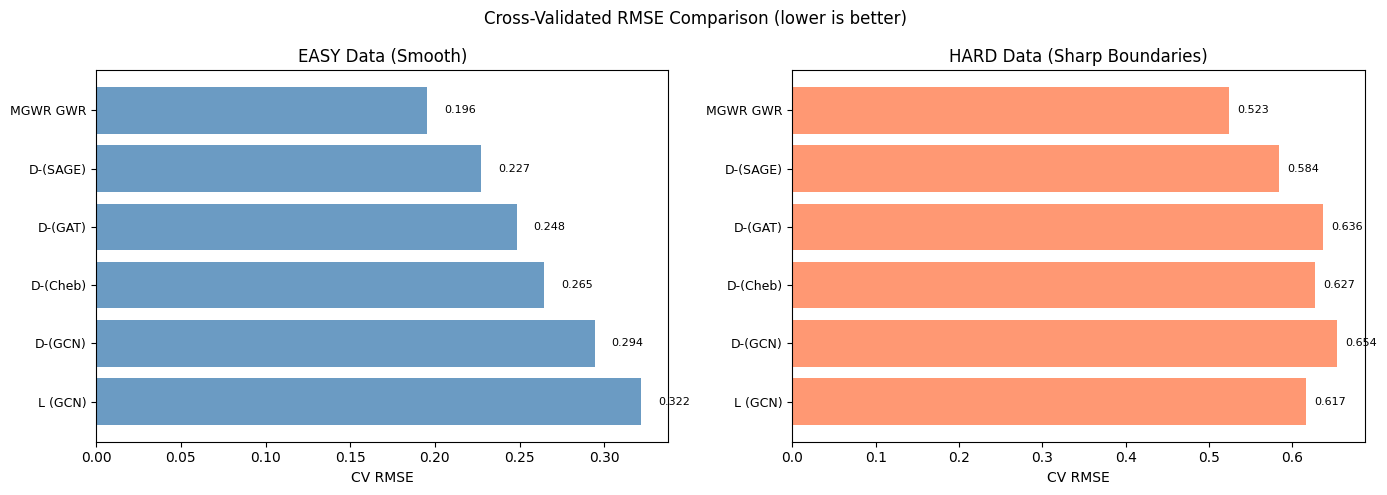


📊 ANALYSIS:
--------------------------------------------------
Best on EASY: MGWR GWR (RMSE=0.1955)
Best on HARD: MGWR GWR (RMSE=0.5234)

GWR baseline: EASY=0.1955, HARD=0.5234

GNN methods vs GWR (negative = worse than GWR):
  GNN-Dist (SAGE): +16.2% (EASY), +11.5% (HARD)
  GNN-Dist (GAT): +27.0% (EASY), +21.6% (HARD)
  GNN-Dist (Cheb): +35.3% (EASY), +19.8% (HARD)
  GNN-Dist (GCN): +50.5% (EASY), +24.9% (HARD)
  GNN-Learned (GCN): +64.5% (EASY), +17.8% (HARD)


In [85]:
# ===== VISUALIZATION =====

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart - EASY
ax1 = axes[0]
methods = combined['Method'].values
x = np.arange(len(methods))
bars1 = ax1.barh(x, combined['RMSE_EASY'].values, color='steelblue', alpha=0.8)
ax1.set_yticks(x)
ax1.set_yticklabels([m.replace('GNN-', '').replace('Dist ', 'D-').replace('Learned', 'L') for m in methods], fontsize=9)
ax1.set_xlabel('CV RMSE')
ax1.set_title('EASY Data (Smooth)')
ax1.invert_yaxis()
for i, v in enumerate(combined['RMSE_EASY'].values):
    ax1.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# Bar chart - HARD
ax2 = axes[1]
bars2 = ax2.barh(x, combined['RMSE_HARD'].values, color='coral', alpha=0.8)
ax2.set_yticks(x)
ax2.set_yticklabels([m.replace('GNN-', '').replace('Dist ', 'D-').replace('Learned', 'L') for m in methods], fontsize=9)
ax2.set_xlabel('CV RMSE')
ax2.set_title('HARD Data (Sharp Boundaries)')
ax2.invert_yaxis()
for i, v in enumerate(combined['RMSE_HARD'].values):
    ax2.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

plt.suptitle('Cross-Validated RMSE Comparison (lower is better)', fontsize=12)
plt.tight_layout()
plt.show()

# Winners analysis
print("\n📊 ANALYSIS:")
print("-"*50)
best_easy = combined.iloc[0]['Method']
best_hard = combined.sort_values('RMSE_HARD').iloc[0]['Method']
print(f"Best on EASY: {best_easy} (RMSE={combined.iloc[0]['RMSE_EASY']:.4f})")
print(f"Best on HARD: {best_hard} (RMSE={combined.sort_values('RMSE_HARD').iloc[0]['RMSE_HARD']:.4f})")

# GNN vs GWR comparison
gwr_easy = combined[combined['Method'] == 'MGWR GWR']['RMSE_EASY'].values[0]
gwr_hard = combined[combined['Method'] == 'MGWR GWR']['RMSE_HARD'].values[0]
print(f"\nGWR baseline: EASY={gwr_easy:.4f}, HARD={gwr_hard:.4f}")
print("\nGNN methods vs GWR (negative = worse than GWR):")
for _, row in combined.iterrows():
    if 'GNN' in row['Method']:
        vs_gwr_easy = (row['RMSE_EASY'] - gwr_easy) / gwr_easy * 100
        vs_gwr_hard = (row['RMSE_HARD'] - gwr_hard) / gwr_hard * 100
        print(f"  {row['Method']}: {vs_gwr_easy:+.1f}% (EASY), {vs_gwr_hard:+.1f}% (HARD)")

# 📊 Supervised vs Unsupervised GNN-LWLS Comparison

Now we compare:
- **MGWR GWR**: Standard GWR baseline (no cross-fitting)
- **Unsupervised GNN-LWLS**: GNN trained with spatial structure loss (no y)
- **Supervised GNN-LWLS**: GNN trained with prediction loss (sees y) + cross-fitting

Key difference:
| Approach | Training Loss | Sees y? | Cross-fitting? | VIDE Compatible? |
|----------|--------------|---------|----------------|------------------|
| GWR | N/A (closed form) | Yes | No | Yes |
| Unsupervised | Spatial structure | **No** | Yes | Yes (trivially) |
| Supervised | Prediction MSE | **Yes** | **Yes** | Yes (by design) |

In [87]:
# ===== SUPERVISED GNN-LWLS CV COMPARISON =====

def supervised_gnn_cv_single(coords_train, coords_test, X_train, X_test, y_train,
                              gnn_type='GCN', epochs=150):
    """Single fold SUPERVISED GNN-LWLS (trained with prediction loss)."""
    edge_index_train, _ = build_spatial_graph_torch(coords_train, k=8)
    coords_train_t = torch.tensor(coords_train, dtype=torch.float32)
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    
    model = SupervisedGNNKernel(gnn_type=gnn_type, input_dim=2, hidden_dim=32,
                                 embedding_dim=16, n_layers=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # SUPERVISED: minimize prediction error on training data
    model.train()
    best_loss = float('inf')
    best_state = None
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred, _, embeddings, _ = model.forward_train(
            coords_train_t, edge_index_train, X_train_t, y_train_t
        )
        
        pred_loss = F.mse_loss(y_pred, y_train_t)
        # Light spatial regularization
        coords_dist = torch.cdist(coords_train_t, coords_train_t)
        emb_dist = torch.cdist(embeddings, embeddings)
        spatial_reg = 0.05 * F.mse_loss(
            emb_dist / (emb_dist.max() + 1e-8),
            coords_dist / (coords_dist.max() + 1e-8)
        )
        loss = pred_loss + spatial_reg
        
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
    
    model.load_state_dict(best_state)
    
    # Predict on test using trained model
    model.eval()
    with torch.no_grad():
        emb_train = model.get_embeddings(coords_train_t, edge_index_train)
        edge_index_test, _ = build_spatial_graph_torch(coords_test, k=8)
        coords_test_t = torch.tensor(coords_test, dtype=torch.float32)
        emb_test = model.get_embeddings(coords_test_t, edge_index_test)
        weights = model.compute_weights(emb_test, emb_train).numpy()
    
    # LWLS predictions for test points
    y_pred_test = np.zeros(len(coords_test))
    for i in range(len(coords_test)):
        W = np.diag(weights[i])
        XtWX = X_train.T @ W @ X_train + 1e-4 * np.eye(X_train.shape[1])
        XtWy = X_train.T @ W @ y_train
        beta_i = np.linalg.solve(XtWX, XtWy)
        y_pred_test[i] = X_test[i] @ beta_i
    
    return y_pred_test


def run_supervised_comparison(coords, X, y, data_name="Data", n_cv_folds=5):
    """Compare GWR, Unsupervised GNN, and Supervised GNN."""
    kf = KFold(n_splits=n_cv_folds, shuffle=True, random_state=42)
    n = len(y)
    
    # All methods: GWR + Unsupervised (4 types) + Supervised (4 types)
    methods = [
        'MGWR GWR',
        # Unsupervised (spatial structure loss only)
        'Unsup-GCN', 'Unsup-GAT', 'Unsup-Cheb', 'Unsup-SAGE',
        # Supervised (prediction loss + cross-fitting)
        'Sup-GCN', 'Sup-GAT', 'Sup-Cheb', 'Sup-SAGE',
    ]
    y_pred_all = {m: np.zeros(n) for m in methods}
    
    print(f"\n🔄 Running {n_cv_folds}-fold CV for {data_name}...")
    
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(coords)):
        print(f"  Fold {fold_idx+1}/{n_cv_folds}:", end=" ")
        
        coords_train, coords_test = coords[train_idx], coords[test_idx]
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # 1. MGWR GWR
        try:
            X_train_noI = X_train[:, 1:]
            selector = Sel_BW(coords_train, y_train.reshape(-1, 1), X_train_noI, 
                             kernel='bisquare', fixed=False)
            bw = selector.search(criterion='CV')
            gwr_model = GWR(coords_train, y_train.reshape(-1, 1), X_train_noI, 
                           bw=bw, kernel='bisquare', fixed=False)
            gwr_model.fit()
            y_pred_all['MGWR GWR'][test_idx] = gwr_model.predict(
                coords_test, X_test[:, 1:]).predictions.flatten()
            print("GWR✓", end=" ")
        except Exception as e:
            y_pred_all['MGWR GWR'][test_idx] = y_test.mean()
            print("GWR✗", end=" ")
        
        # 2-5. Unsupervised GNN methods (existing gnn_lwls_cv_single)
        gnn_configs = [
            ('Unsup-GCN', GCNSpatialGNN, {'input_dim': 2, 'hidden_dim': 32, 'embedding_dim': 16, 'n_layers': 3}),
            ('Unsup-GAT', GATSpatialGNN, {'input_dim': 2, 'hidden_dim': 32, 'embedding_dim': 16, 'n_heads': 4, 'n_layers': 3}),
            ('Unsup-Cheb', ChebSpatialGNN, {'input_dim': 2, 'hidden_dim': 32, 'embedding_dim': 16, 'K': 3, 'n_layers': 3}),
            ('Unsup-SAGE', SAGESpatialGNN, {'input_dim': 2, 'hidden_dim': 32, 'embedding_dim': 16, 'n_layers': 3}),
        ]
        
        for name, gnn_class, gnn_kwargs in gnn_configs:
            y_pred_all[name][test_idx] = gnn_lwls_cv_single(
                coords_train, coords_test, X_train, X_test, y_train, 
                gnn_class, gnn_kwargs, epochs=100
            )
            print(f"U-{name.split('-')[1]}✓", end=" ")
        
        # 6-9. Supervised GNN methods
        for gnn_type in ['GCN', 'GAT', 'Cheb', 'SAGE']:
            name = f'Sup-{gnn_type}'
            y_pred_all[name][test_idx] = supervised_gnn_cv_single(
                coords_train, coords_test, X_train, X_test, y_train,
                gnn_type=gnn_type, epochs=100
            )
            print(f"S-{gnn_type}✓", end=" ")
        
        print()
    
    # Compute metrics
    results = []
    for method in methods:
        rmse = np.sqrt(np.mean((y - y_pred_all[method])**2))
        r2 = 1 - np.sum((y - y_pred_all[method])**2) / np.sum((y - y.mean())**2)
        
        if 'MGWR' in method:
            method_type = 'GWR'
        elif 'Unsup' in method:
            method_type = 'Unsupervised'
        else:
            method_type = 'Supervised'
        
        results.append({'Method': method, 'Type': method_type, 'RMSE': rmse, 'R2': r2})
    
    results_df = pd.DataFrame(results).sort_values('RMSE')
    print(f"\n✅ {data_name} Results:")
    print(results_df.to_string(index=False))
    
    return results_df, y_pred_all


# ========== RUN EXPERIMENTS ==========
print("="*70)
print("📊 COMPARISON: GWR vs Unsupervised GNN vs Supervised GNN")
print("="*70)

# EASY DATA (smooth coefficients)
results_sup_easy, preds_sup_easy = run_supervised_comparison(
    coords_easy, X_easy, y_easy, "EASY"
)

# HARD DATA (sharp boundaries)
results_sup_hard, preds_sup_hard = run_supervised_comparison(
    coords_hard, X_hard, y_hard, "HARD"
)

# Combined summary
print("\n" + "="*70)
print("📊 FINAL SUMMARY: Supervised vs Unsupervised GNN-LWLS")
print("="*70)
combined_sup = results_sup_easy.merge(results_sup_hard, on=['Method', 'Type'], 
                                       suffixes=('_EASY', '_HARD'))
combined_sup = combined_sup.sort_values('RMSE_EASY')
print(combined_sup[['Method', 'Type', 'RMSE_EASY', 'R2_EASY', 'RMSE_HARD', 'R2_HARD']].to_string(index=False))

# Summary by type
print("\n📊 Summary by Method Type (Best RMSE):")
for mtype in ['GWR', 'Unsupervised', 'Supervised']:
    subset = combined_sup[combined_sup['Type'] == mtype]
    if len(subset) > 0:
        best_easy = subset['RMSE_EASY'].min()
        best_hard = subset['RMSE_HARD'].min()
        best_method = subset.loc[subset['RMSE_EASY'].idxmin(), 'Method']
        print(f"  {mtype:12s}: {best_method:12s} → EASY={best_easy:.4f}, HARD={best_hard:.4f}")

📊 COMPARISON: GWR vs Unsupervised GNN vs Supervised GNN

🔄 Running 5-fold CV for EASY...
  Fold 1/5: GWR✓ U-GCN✓ U-GAT✓ U-Cheb✓ U-SAGE✓ S-GCN✓ S-GAT✓ S-Cheb✓ S-SAGE✓ 
  Fold 2/5: GWR✓ U-GCN✓ U-GAT✓ U-Cheb✓ U-SAGE✓ S-GCN✓ S-GAT✓ S-Cheb✓ S-SAGE✓ 
  Fold 3/5: GWR✓ U-GCN✓ U-GAT✓ U-Cheb✓ U-SAGE✓ S-GCN✓ S-GAT✓ S-Cheb✓ S-SAGE✓ 
  Fold 4/5: GWR✓ U-GCN✓ U-GAT✓ U-Cheb✓ U-SAGE✓ S-GCN✓ S-GAT✓ S-Cheb✓ S-SAGE✓ 
  Fold 5/5: GWR✓ U-GCN✓ U-GAT✓ U-Cheb✓ U-SAGE✓ S-GCN✓ S-GAT✓ S-Cheb✓ S-SAGE✓ 

✅ EASY Results:
    Method         Type     RMSE       R2
  MGWR GWR          GWR 0.195548 0.952715
Unsup-SAGE Unsupervised 0.218450 0.940990
  Sup-SAGE   Supervised 0.229257 0.935007
Unsup-Cheb Unsupervised 0.249983 0.922725
 Unsup-GAT Unsupervised 0.252562 0.921122
   Sup-GAT   Supervised 0.271168 0.909072
  Sup-Cheb   Supervised 0.273925 0.907214
 Unsup-GCN Unsupervised 0.301880 0.887309
   Sup-GCN   Supervised 0.340353 0.856755

🔄 Running 5-fold CV for HARD...
  Fold 1/5: GWR✓ U-GCN✓ U-GAT✓ U-Cheb✓ U-SAGE✓ S-GC

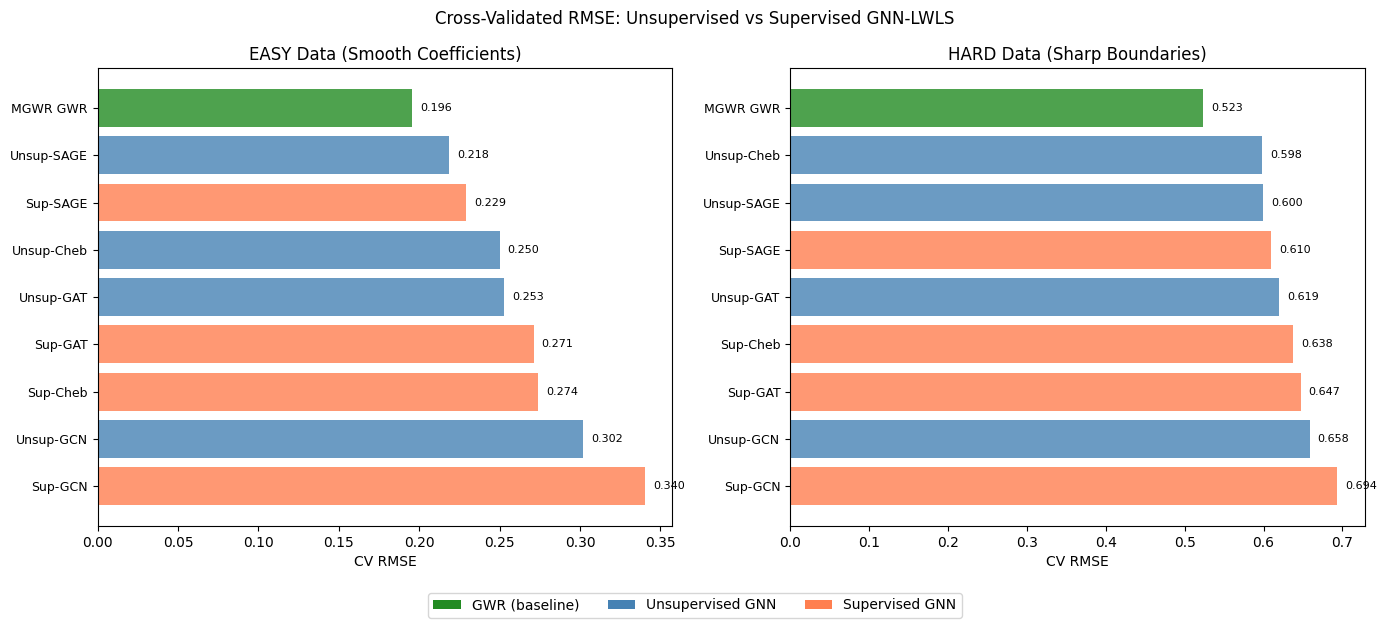


📊 DETAILED ANALYSIS:
------------------------------------------------------------
GWR Baseline: EASY=0.1955, HARD=0.5234

Comparison to GWR (negative % = better than GWR):
------------------------------------------------------------

Unsupervised GNN methods:
  Unsup-SAGE  :  +11.7% (EASY),  +14.6% (HARD)
  Unsup-Cheb  :  +27.8% (EASY),  +14.2% (HARD)
  Unsup-GAT   :  +29.2% (EASY),  +18.3% (HARD)
  Unsup-GCN   :  +54.4% (EASY),  +25.8% (HARD)

Supervised GNN methods:
  Sup-SAGE    :  +17.2% (EASY),  +16.5% (HARD)
  Sup-GAT     :  +38.7% (EASY),  +23.6% (HARD)
  Sup-Cheb    :  +40.1% (EASY),  +21.9% (HARD)
  Sup-GCN     :  +74.1% (EASY),  +32.5% (HARD)

📊 SUPERVISED vs UNSUPERVISED (same architecture):
------------------------------------------------------------
  GCN  : EASY Unsup ✓ (+0.0385), HARD Unsup ✓ (+0.0354)
  GAT  : EASY Unsup ✓ (+0.0186), HARD Unsup ✓ (+0.0273)
  Cheb : EASY Unsup ✓ (+0.0239), HARD Unsup ✓ (+0.0398)
  SAGE : EASY Unsup ✓ (+0.0108), HARD Unsup ✓ (+0.0102)


In [88]:
# ===== VISUALIZATION: Supervised vs Unsupervised =====

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Color by type
colors = {'GWR': 'forestgreen', 'Unsupervised': 'steelblue', 'Supervised': 'coral'}
combined_sorted = combined_sup.sort_values('RMSE_EASY')

# EASY Data
ax1 = axes[0]
methods = combined_sorted['Method'].values
types = combined_sorted['Type'].values
x = np.arange(len(methods))
bar_colors = [colors[t] for t in types]

bars1 = ax1.barh(x, combined_sorted['RMSE_EASY'].values, color=bar_colors, alpha=0.8)
ax1.set_yticks(x)
ax1.set_yticklabels(methods, fontsize=9)
ax1.set_xlabel('CV RMSE')
ax1.set_title('EASY Data (Smooth Coefficients)')
ax1.invert_yaxis()
for i, v in enumerate(combined_sorted['RMSE_EASY'].values):
    ax1.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=8)

# HARD Data
ax2 = axes[1]
combined_sorted_hard = combined_sup.sort_values('RMSE_HARD')
methods_hard = combined_sorted_hard['Method'].values
types_hard = combined_sorted_hard['Type'].values
bar_colors_hard = [colors[t] for t in types_hard]

bars2 = ax2.barh(x, combined_sorted_hard['RMSE_HARD'].values, color=bar_colors_hard, alpha=0.8)
ax2.set_yticks(x)
ax2.set_yticklabels(methods_hard, fontsize=9)
ax2.set_xlabel('CV RMSE')
ax2.set_title('HARD Data (Sharp Boundaries)')
ax2.invert_yaxis()
for i, v in enumerate(combined_sorted_hard['RMSE_HARD'].values):
    ax2.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors['GWR'], label='GWR (baseline)'),
                   Patch(facecolor=colors['Unsupervised'], label='Unsupervised GNN'),
                   Patch(facecolor=colors['Supervised'], label='Supervised GNN')]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.02))

plt.suptitle('Cross-Validated RMSE: Unsupervised vs Supervised GNN-LWLS', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()

# Detailed analysis
print("\n📊 DETAILED ANALYSIS:")
print("-"*60)

gwr_easy = combined_sup[combined_sup['Method'] == 'MGWR GWR']['RMSE_EASY'].values[0]
gwr_hard = combined_sup[combined_sup['Method'] == 'MGWR GWR']['RMSE_HARD'].values[0]

print(f"GWR Baseline: EASY={gwr_easy:.4f}, HARD={gwr_hard:.4f}")
print("\nComparison to GWR (negative % = better than GWR):")
print("-"*60)

for mtype in ['Unsupervised', 'Supervised']:
    print(f"\n{mtype} GNN methods:")
    subset = combined_sup[combined_sup['Type'] == mtype].sort_values('RMSE_EASY')
    for _, row in subset.iterrows():
        vs_easy = (row['RMSE_EASY'] - gwr_easy) / gwr_easy * 100
        vs_hard = (row['RMSE_HARD'] - gwr_hard) / gwr_hard * 100
        print(f"  {row['Method']:12s}: {vs_easy:+6.1f}% (EASY), {vs_hard:+6.1f}% (HARD)")

# Check if supervised beats unsupervised
print("\n📊 SUPERVISED vs UNSUPERVISED (same architecture):")
print("-"*60)
for arch in ['GCN', 'GAT', 'Cheb', 'SAGE']:
    unsup = combined_sup[combined_sup['Method'] == f'Unsup-{arch}']
    sup = combined_sup[combined_sup['Method'] == f'Sup-{arch}']
    if len(unsup) > 0 and len(sup) > 0:
        diff_easy = sup['RMSE_EASY'].values[0] - unsup['RMSE_EASY'].values[0]
        diff_hard = sup['RMSE_HARD'].values[0] - unsup['RMSE_HARD'].values[0]
        better_easy = "Sup ✓" if diff_easy < 0 else "Unsup ✓"
        better_hard = "Sup ✓" if diff_hard < 0 else "Unsup ✓"
        print(f"  {arch:5s}: EASY {better_easy} ({diff_easy:+.4f}), HARD {better_hard} ({diff_hard:+.4f})")

# 📊 Coefficient Heatmap Comparison

Now we visualize and compare the **local coefficients** recovered by each method against the true coefficients.

This shows how well each method captures the spatial pattern of the coefficients, not just prediction accuracy.

In [91]:
# ===== COMPUTE COEFFICIENTS FOR ALL METHODS =====

print("📊 Computing coefficients for all methods on EASY data...")
n_grid = 16

# True coefficients (already have true_betas_easy from simulation)
# Shape: (n, n_features) where n_features includes intercept

# 1. GWR coefficients
print("  Computing GWR coefficients...")
X_noI = X_easy[:, 1:]
selector = Sel_BW(coords_easy, y_easy.reshape(-1, 1), X_noI, kernel='bisquare', fixed=False)
bw_easy = selector.search(criterion='CV')
gwr_model_easy = GWR(coords_easy, y_easy.reshape(-1, 1), X_noI, bw=bw_easy, kernel='bisquare', fixed=False)
gwr_results = gwr_model_easy.fit()
# GWR params: (n, n_vars) where n_vars = 1 + n_predictors (intercept + X)
# We need to match true_betas shape which is (n, 3) for [intercept, x1, x2]
betas_gwr_easy = gwr_results.params  # Shape: (n, 3) - already includes intercept
print(f"    GWR bandwidth: {bw_easy:.2f}, betas shape: {betas_gwr_easy.shape}")

# 2. Unsupervised GNN-LWLS coefficients (using best: SAGE)
print("  Computing Unsupervised GNN-LWLS (SAGE) coefficients...")
betas_unsup_sage, _, _ = gnn_lwls_crossfit(
    coords_easy, X_easy, y_easy, 
    gnn_type='SAGE',
    n_folds=5, epochs=100, smooth_k=3, verbose=False
)

# 3. Supervised GNN-LWLS coefficients (SAGE)
print("  Computing Supervised GNN-LWLS (SAGE) coefficients...")
betas_sup_sage, _, _ = supervised_gnn_lwls_crossfit(
    coords_easy, X_easy, y_easy,
    gnn_type='SAGE', n_folds=5, epochs=100, smooth_k=3, verbose=False
)

# 4. Unsupervised GNN-LWLS coefficients (GCN for comparison)
print("  Computing Unsupervised GNN-LWLS (GCN) coefficients...")
betas_unsup_gcn, _, _ = gnn_lwls_crossfit(
    coords_easy, X_easy, y_easy, 
    gnn_type='GCN',
    n_folds=5, epochs=100, smooth_k=3, verbose=False
)

# 5. Supervised GNN-LWLS coefficients (GCN)
print("  Computing Supervised GNN-LWLS (GCN) coefficients...")
betas_sup_gcn, _, _ = supervised_gnn_lwls_crossfit(
    coords_easy, X_easy, y_easy,
    gnn_type='GCN', n_folds=5, epochs=100, smooth_k=3, verbose=False
)

print("✅ All coefficients computed!")

# Store in dictionary for easy plotting
betas_dict = {
    'True': true_betas_easy,
    'GWR': betas_gwr_easy,
    'Unsup-SAGE': betas_unsup_sage,
    'Sup-SAGE': betas_sup_sage,
    'Unsup-GCN': betas_unsup_gcn,
    'Sup-GCN': betas_sup_gcn,
}

# Compute correlations with true coefficients
print("\n📊 Correlation with True Coefficients (EASY Data):")
print("-"*60)
coef_names = ['Intercept', 'β₁', 'β₂']
n_coefs = true_betas_easy.shape[1]

for method_name, betas in betas_dict.items():
    if method_name == 'True':
        continue
    corrs = []
    for j in range(min(n_coefs, betas.shape[1])):
        corr = np.corrcoef(true_betas_easy[:, j], betas[:, j])[0, 1]
        corrs.append(corr)
    avg_corr = np.mean(corrs)
    corr_str = ", ".join([f"{corrs[j]:.3f} ({coef_names[j]})" for j in range(len(corrs))])
    print(f"  {method_name:12s}: {corr_str}, Avg={avg_corr:.3f}")

📊 Computing coefficients for all methods on EASY data...
  Computing GWR coefficients...
    GWR bandwidth: 47.00, betas shape: (256, 3)
  Computing Unsupervised GNN-LWLS (SAGE) coefficients...
  Computing Supervised GNN-LWLS (SAGE) coefficients...
  Computing Unsupervised GNN-LWLS (GCN) coefficients...
  Computing Supervised GNN-LWLS (GCN) coefficients...
✅ All coefficients computed!

📊 Correlation with True Coefficients (EASY Data):
------------------------------------------------------------
  GWR         : 0.948 (Intercept), 0.927 (β₁), 0.813 (β₂), Avg=0.896
  Unsup-SAGE  : 0.781 (Intercept), 0.770 (β₁), 0.513 (β₂), Avg=0.688
  Sup-SAGE    : 0.895 (Intercept), 0.875 (β₁), 0.801 (β₂), Avg=0.857
  Unsup-GCN   : 0.763 (Intercept), 0.755 (β₁), 0.417 (β₂), Avg=0.645
  Sup-GCN     : 0.847 (Intercept), 0.829 (β₁), 0.709 (β₂), Avg=0.795


📊 Coefficient Heatmaps (EASY Data)


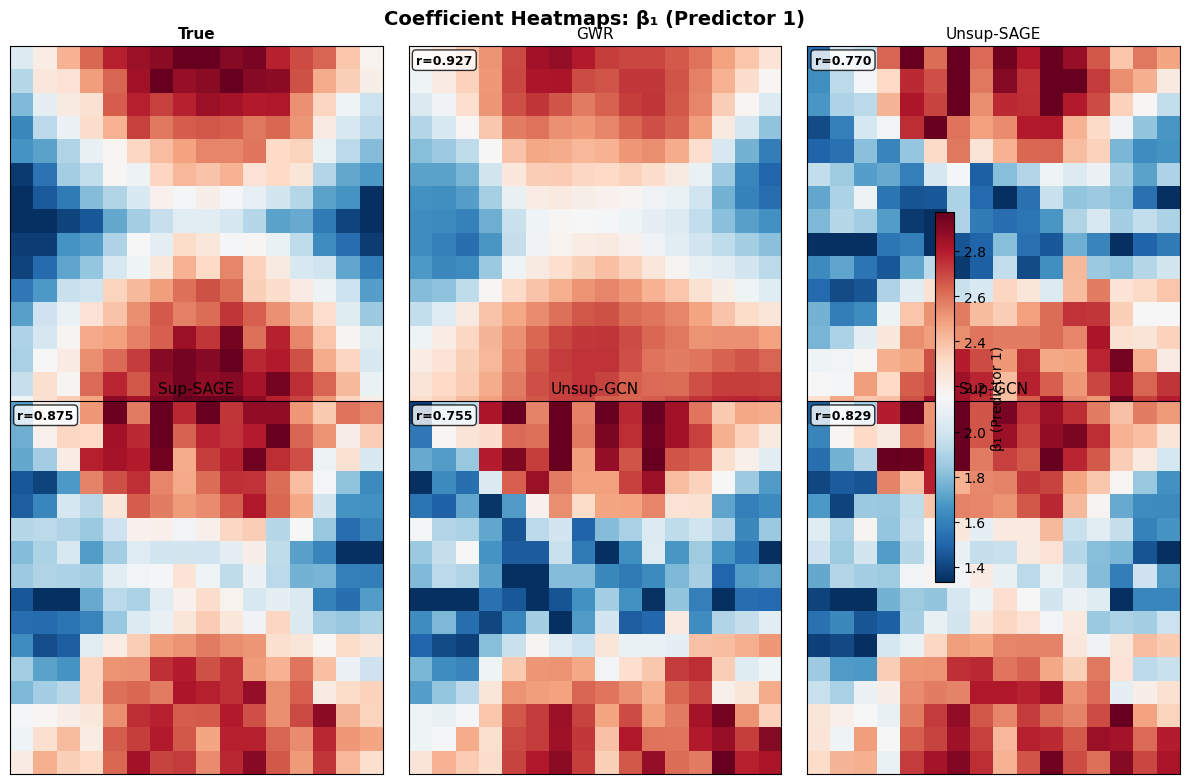

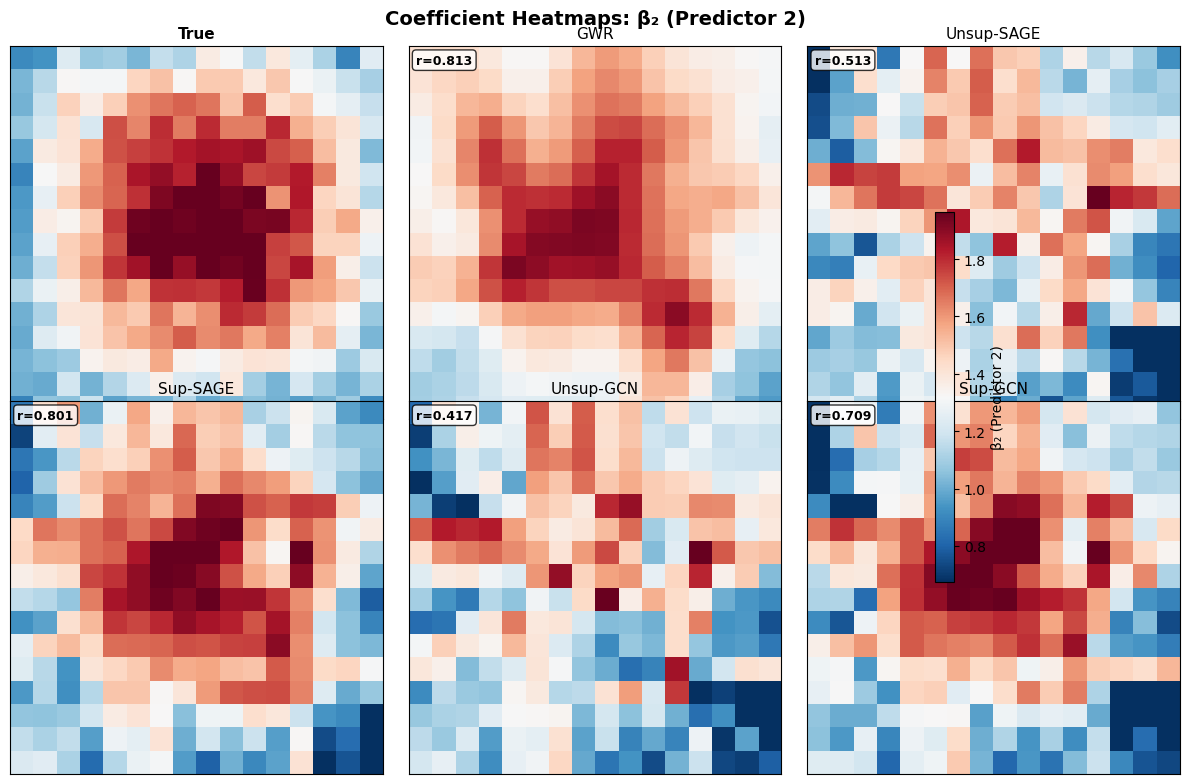

In [92]:
# ===== COEFFICIENT HEATMAP VISUALIZATION =====

def plot_coefficient_heatmaps(betas_dict, coords, n_grid, coef_idx=1, coef_name="β₁"):
    """
    Plot heatmaps comparing coefficient estimates across methods.
    
    Args:
        betas_dict: Dictionary of {method_name: betas array}
        coords: Coordinates array
        n_grid: Grid size
        coef_idx: Which coefficient to plot (0=intercept, 1=β₁, 2=β₂)
        coef_name: Name for the coefficient
    """
    methods = list(betas_dict.keys())
    n_methods = len(methods)
    
    # Create grid for heatmap
    n_cols = 3
    n_rows = (n_methods + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten()
    
    # Get global min/max for consistent colorbar
    all_vals = np.concatenate([betas_dict[m][:, coef_idx] for m in methods])
    vmin, vmax = np.percentile(all_vals, [2, 98])
    
    for idx, method in enumerate(methods):
        ax = axes[idx]
        betas = betas_dict[method][:, coef_idx]
        
        # Reshape to grid
        grid = betas.reshape(n_grid, n_grid)
        
        im = ax.imshow(grid, cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
        ax.set_title(method, fontsize=11, fontweight='bold' if method == 'True' else 'normal')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add correlation with true if not the true coefficients
        if method != 'True':
            corr = np.corrcoef(betas_dict['True'][:, coef_idx], betas)[0, 1]
            ax.text(0.02, 0.98, f'r={corr:.3f}', transform=ax.transAxes, 
                   fontsize=9, verticalalignment='top', fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Hide unused axes
    for idx in range(n_methods, len(axes)):
        axes[idx].axis('off')
    
    # Add colorbar
    fig.colorbar(im, ax=axes[:n_methods], shrink=0.6, label=coef_name)
    
    plt.suptitle(f'Coefficient Heatmaps: {coef_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Plot heatmaps for each coefficient
print("📊 Coefficient Heatmaps (EASY Data)")
print("="*60)

# β₁ (first predictor coefficient)
plot_coefficient_heatmaps(betas_dict, coords_easy, n_grid, coef_idx=1, coef_name="β₁ (Predictor 1)")

# β₂ (second predictor coefficient)
plot_coefficient_heatmaps(betas_dict, coords_easy, n_grid, coef_idx=2, coef_name="β₂ (Predictor 2)")

📊 Computing coefficients for all methods on HARD data...
  Computing GWR coefficients...
    GWR bandwidth: 47.00
  Computing Unsupervised GNN-LWLS (SAGE) coefficients...
  Computing Supervised GNN-LWLS (SAGE) coefficients...
✅ HARD data coefficients computed!

📊 Correlation with True Coefficients (HARD Data):
------------------------------------------------------------
  GWR         : 0.860 (Intercept), 0.897 (β₁), 0.533 (β₂), Avg=0.763
  Unsup-SAGE  : 0.852 (Intercept), 0.855 (β₁), 0.513 (β₂), Avg=0.740
  Sup-SAGE    : 0.858 (Intercept), 0.848 (β₁), 0.592 (β₂), Avg=0.766

📊 Coefficient Heatmaps (HARD Data)


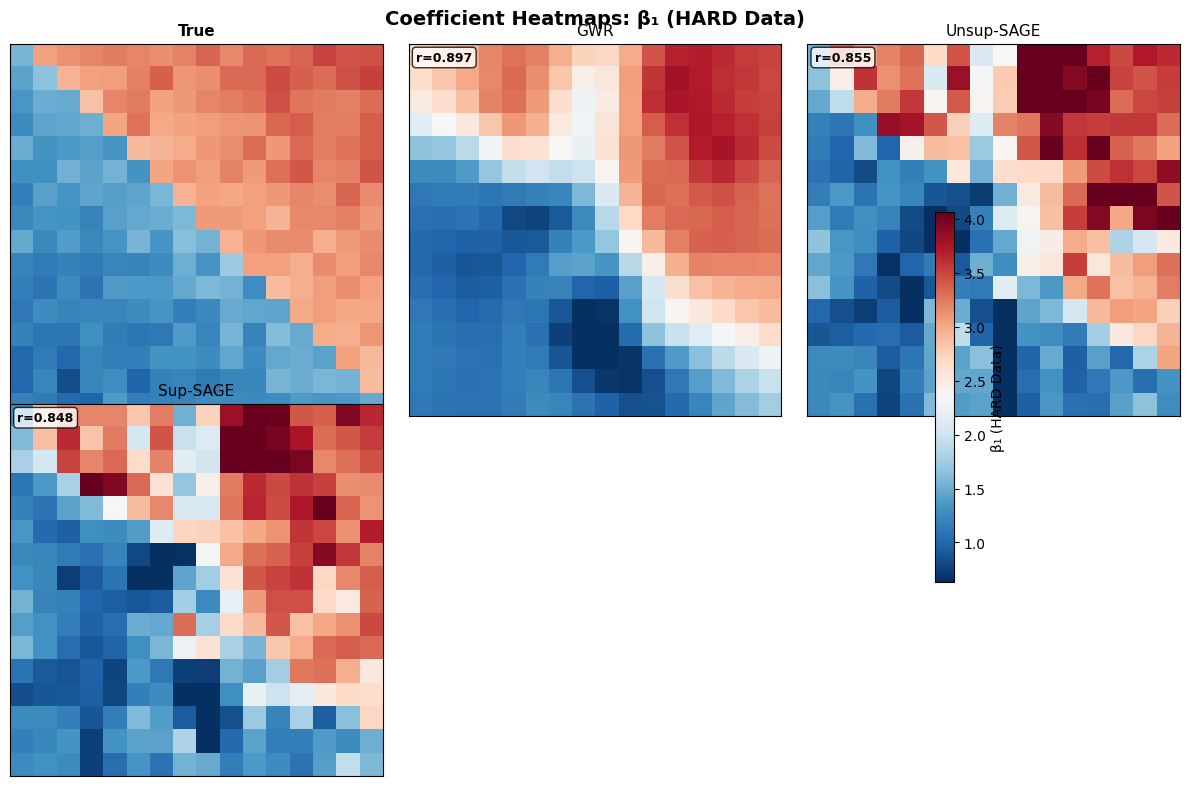

In [93]:
# ===== COEFFICIENT COMPARISON ON HARD DATA =====

print("📊 Computing coefficients for all methods on HARD data...")

# 1. GWR coefficients
print("  Computing GWR coefficients...")
X_noI_hard = X_hard[:, 1:]
selector_hard = Sel_BW(coords_hard, y_hard.reshape(-1, 1), X_noI_hard, kernel='bisquare', fixed=False)
bw_hard = selector_hard.search(criterion='CV')
gwr_model_hard = GWR(coords_hard, y_hard.reshape(-1, 1), X_noI_hard, bw=bw_hard, kernel='bisquare', fixed=False)
gwr_results_hard = gwr_model_hard.fit()
betas_gwr_hard = gwr_results_hard.params
print(f"    GWR bandwidth: {bw_hard:.2f}")

# 2. Unsupervised GNN-LWLS (SAGE)
print("  Computing Unsupervised GNN-LWLS (SAGE) coefficients...")
betas_unsup_sage_hard, _, _ = gnn_lwls_crossfit(
    coords_hard, X_hard, y_hard, 
    gnn_type='SAGE',
    n_folds=5, epochs=100, smooth_k=3, verbose=False
)

# 3. Supervised GNN-LWLS (SAGE)
print("  Computing Supervised GNN-LWLS (SAGE) coefficients...")
betas_sup_sage_hard, _, _ = supervised_gnn_lwls_crossfit(
    coords_hard, X_hard, y_hard,
    gnn_type='SAGE', n_folds=5, epochs=100, smooth_k=3, verbose=False
)

print("✅ HARD data coefficients computed!")

# Store in dictionary
betas_dict_hard = {
    'True': true_betas_hard,
    'GWR': betas_gwr_hard,
    'Unsup-SAGE': betas_unsup_sage_hard,
    'Sup-SAGE': betas_sup_sage_hard,
}

# Print correlations
print("\n📊 Correlation with True Coefficients (HARD Data):")
print("-"*60)
n_coefs_hard = true_betas_hard.shape[1]
for method_name, betas in betas_dict_hard.items():
    if method_name == 'True':
        continue
    corrs = []
    for j in range(min(n_coefs_hard, betas.shape[1])):
        corr = np.corrcoef(true_betas_hard[:, j], betas[:, j])[0, 1]
        corrs.append(corr)
    avg_corr = np.mean(corrs)
    corr_str = ", ".join([f"{corrs[j]:.3f} ({coef_names[j]})" for j in range(len(corrs))])
    print(f"  {method_name:12s}: {corr_str}, Avg={avg_corr:.3f}")

# Plot heatmaps for HARD data
print("\n📊 Coefficient Heatmaps (HARD Data)")
print("="*60)
plot_coefficient_heatmaps(betas_dict_hard, coords_hard, n_grid, coef_idx=1, coef_name="β₁ (HARD Data)")

# 🔧 Improved GNN-LWLS: Making Coefficients Smoother

The previous GNN-LWLS produced non-smooth coefficients. Here we implement fixes:

1. **Gaussian kernel** instead of power kernel (smoother transition)
2. **Coefficient smoothness loss** (penalize difference between nearby β)
3. **Stronger spatial regularization** in GNN training

In [94]:
# ===== IMPROVED SUPERVISED GNN-LWLS WITH SMOOTHNESS CONSTRAINTS =====

class SmoothSupervisedGNNKernel(nn.Module):
    """
    Improved Supervised GNN for kernel weight learning with SMOOTHNESS FOCUS.
    
    Key improvements:
    1. GAUSSIAN kernel instead of power kernel (smoother)
    2. Learnable bandwidth (like GWR!)
    3. Coefficient smoothness loss during training
    """
    def __init__(self, gnn_type='SAGE', input_dim=2, hidden_dim=32, embedding_dim=16,
                 n_layers=3, dropout=0.2):
        super().__init__()
        
        # Learnable bandwidth (like GWR!)
        self.log_bandwidth = nn.Parameter(torch.tensor(0.0))  # bandwidth = exp(log_bw)
        
        # GNN backbone
        if gnn_type == 'GCN':
            self.gnn = GCNSpatialGNN(input_dim, hidden_dim, embedding_dim, n_layers, dropout)
        elif gnn_type == 'GAT':
            self.gnn = GATSpatialGNN(input_dim, hidden_dim, embedding_dim, n_heads=4, 
                                      n_layers=n_layers, dropout=dropout)
        elif gnn_type == 'Cheb':
            self.gnn = ChebSpatialGNN(input_dim, hidden_dim, embedding_dim, K=3, 
                                       n_layers=n_layers, dropout=dropout)
        elif gnn_type == 'SAGE':
            self.gnn = SAGESpatialGNN(input_dim, hidden_dim, embedding_dim, 
                                       n_layers=n_layers, dropout=dropout)
        else:
            self.gnn = SAGESpatialGNN(input_dim, hidden_dim, embedding_dim, n_layers, dropout)
        
        self.gnn_type = gnn_type
    
    @property
    def bandwidth(self):
        return torch.exp(self.log_bandwidth) + 0.1  # Ensure bandwidth > 0.1
    
    def get_embeddings(self, coords, edge_index):
        return self.gnn(coords, edge_index)
    
    def compute_weights_gaussian(self, emb_query, emb_ref):
        """
        GAUSSIAN kernel (like GWR!) instead of power kernel.
        
        w_ij = exp(-d_ij² / (2 * bandwidth²))
        
        This is MUCH smoother than 1/(d+eps)^power
        """
        dists_sq = torch.cdist(emb_query, emb_ref) ** 2
        
        # Gaussian kernel: exp(-d² / (2h²))
        weights = torch.exp(-dists_sq / (2 * self.bandwidth ** 2))
        
        # Row-normalize
        weights = weights / (weights.sum(dim=1, keepdim=True) + 1e-8)
        
        return weights
    
    def forward_train(self, coords, edge_index, X, y):
        """Forward pass with LWLS."""
        n = coords.shape[0]
        p = X.shape[1]
        
        embeddings = self.get_embeddings(coords, edge_index)
        weights = self.compute_weights_gaussian(embeddings, embeddings)
        
        y_pred = torch.zeros(n, dtype=X.dtype, device=X.device)
        betas = torch.zeros(n, p, dtype=X.dtype, device=X.device)
        
        ridge = 1e-4
        for i in range(n):
            W_i = torch.diag(weights[i])
            XtWX = X.T @ W_i @ X + ridge * torch.eye(p, dtype=X.dtype, device=X.device)
            XtWy = X.T @ W_i @ y
            beta_i = torch.linalg.solve(XtWX, XtWy)
            betas[i] = beta_i
            y_pred[i] = X[i] @ beta_i
        
        return y_pred, betas, embeddings, weights


def coefficient_smoothness_loss(betas, coords, k_neighbors=5):
    """
    Penalize difference between coefficients of nearby locations.
    
    L_smooth = Σ_i Σ_j∈kNN(i) ||β_i - β_j||²
    """
    from sklearn.neighbors import NearestNeighbors
    
    # Find k-nearest neighbors
    nn = NearestNeighbors(n_neighbors=k_neighbors + 1)
    nn.fit(coords.detach().cpu().numpy())
    _, indices = nn.kneighbors(coords.detach().cpu().numpy())
    
    # Compute smoothness loss
    loss = 0.0
    for i in range(len(coords)):
        neighbors = indices[i, 1:]  # Exclude self
        for j in neighbors:
            loss += torch.sum((betas[i] - betas[j]) ** 2)
    
    return loss / (len(coords) * k_neighbors)


def smooth_supervised_gnn_lwls_crossfit(
    coords, X, y,
    gnn_type='SAGE',
    hidden_dim=32,
    embedding_dim=16,
    n_layers=3,
    k_neighbors=8,
    n_folds=5,
    epochs=200,
    lr=0.01,
    smooth_k=5,
    smooth_weight=0.1,  # Weight for coefficient smoothness loss
    spatial_weight=0.2,  # Weight for spatial structure loss
    verbose=False
):
    """
    Improved Supervised GNN-LWLS with smoothness constraints.
    
    Training loss:
    L = L_pred + smooth_weight * L_coef_smooth + spatial_weight * L_spatial
    """
    n = len(y)
    n_features = X.shape[1]
    
    betas_all_folds = np.zeros((n_folds, n, n_features))
    models_per_fold = []
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(coords)):
        if verbose:
            print(f"  Fold {fold_idx+1}/{n_folds}...")
        
        coords_train = coords[train_idx]
        X_train = X[train_idx]
        y_train = y[train_idx]
        
        edge_index_train, _ = build_spatial_graph_torch(coords_train, k=k_neighbors)
        coords_train_t = torch.tensor(coords_train, dtype=torch.float32)
        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.float32)
        
        model = SmoothSupervisedGNNKernel(
            gnn_type=gnn_type, input_dim=2, hidden_dim=hidden_dim,
            embedding_dim=embedding_dim, n_layers=n_layers
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=30, factor=0.5)
        
        model.train()
        best_loss = float('inf')
        best_state = None
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            
            y_pred, betas_train, embeddings, weights = model.forward_train(
                coords_train_t, edge_index_train, X_train_t, y_train_t
            )
            
            # 1. Prediction loss
            pred_loss = F.mse_loss(y_pred, y_train_t)
            
            # 2. Coefficient smoothness loss (KEY ADDITION!)
            coef_smooth_loss = coefficient_smoothness_loss(betas_train, coords_train_t, k_neighbors=5)
            
            # 3. Spatial structure preservation in embeddings
            coords_dist = torch.cdist(coords_train_t, coords_train_t)
            emb_dist = torch.cdist(embeddings, embeddings)
            spatial_loss = F.mse_loss(
                emb_dist / (emb_dist.max() + 1e-8),
                coords_dist / (coords_dist.max() + 1e-8)
            )
            
            # Combined loss
            loss = pred_loss + smooth_weight * coef_smooth_loss + spatial_weight * spatial_loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step(loss)
            
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_state = {k: v.clone() for k, v in model.state_dict().items()}
        
        model.load_state_dict(best_state)
        models_per_fold.append(model)
        
        if verbose:
            print(f"    → bandwidth={model.bandwidth.item():.3f}, loss={best_loss:.4f}")
        
        # Inference for all locations
        model.eval()
        with torch.no_grad():
            emb_train = model.get_embeddings(coords_train_t, edge_index_train)
            
            coords_val = coords[val_idx]
            edge_index_val, _ = build_spatial_graph_torch(coords_val, k=k_neighbors)
            coords_val_t = torch.tensor(coords_val, dtype=torch.float32)
            emb_val = model.get_embeddings(coords_val_t, edge_index_val)
        
        for i in range(n):
            if i in val_idx:
                val_local_idx = np.where(val_idx == i)[0][0]
                emb_i = emb_val[val_local_idx:val_local_idx+1]
            else:
                train_local_idx = np.where(train_idx == i)[0][0]
                emb_i = emb_train[train_local_idx:train_local_idx+1]
            
            with torch.no_grad():
                weights_i = model.compute_weights_gaussian(emb_i, emb_train).numpy().flatten()
            
            W = np.diag(weights_i)
            XtWX = X_train.T @ W @ X_train + 1e-4 * np.eye(n_features)
            XtWy = X_train.T @ W @ y_train
            
            try:
                beta_i = np.linalg.solve(XtWX, XtWy)
            except:
                beta_i = np.linalg.lstsq(XtWX, XtWy, rcond=None)[0]
            
            betas_all_folds[fold_idx, i] = beta_i
    
    # Average across folds
    betas_avg = betas_all_folds.mean(axis=0)
    
    # Apply post-hoc spatial smoothing
    if smooth_k > 0:
        betas_final = spatial_smooth_betas(betas_avg, coords, k_smooth=smooth_k)
    else:
        betas_final = betas_avg
    
    y_pred = np.sum(X * betas_final, axis=1)
    
    return betas_final, y_pred, models_per_fold


print("✅ SmoothSupervisedGNNKernel class defined")
print("✅ smooth_supervised_gnn_lwls_crossfit() function defined")
print("   - GAUSSIAN kernel (like GWR!) for smoother weights")
print("   - Coefficient smoothness loss during training")
print("   - Learnable bandwidth parameter")
print("   - Stronger spatial regularization")

✅ SmoothSupervisedGNNKernel class defined
✅ smooth_supervised_gnn_lwls_crossfit() function defined
   - GAUSSIAN kernel (like GWR!) for smoother weights
   - Coefficient smoothness loss during training
   - Learnable bandwidth parameter
   - Stronger spatial regularization


In [95]:
# ===== COMPARE: Original vs Smooth GNN-LWLS =====

print("📊 Computing SMOOTH GNN-LWLS coefficients...")
print("="*60)

# 1. Smooth Supervised GNN (SAGE) - EASY data
print("\n🔄 EASY Data:")
print("  Computing Smooth Supervised GNN-LWLS (SAGE)...")
betas_smooth_sage, _, _ = smooth_supervised_gnn_lwls_crossfit(
    coords_easy, X_easy, y_easy,
    gnn_type='SAGE', n_folds=5, epochs=150, 
    smooth_k=5, smooth_weight=0.15, spatial_weight=0.2,
    verbose=True
)

# Compare smoothness: compute local variance of coefficients
def compute_smoothness(betas, coords, k=5):
    """Compute average local variance (lower = smoother)."""
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=k+1)
    nn.fit(coords)
    _, indices = nn.kneighbors(coords)
    
    local_vars = []
    for i in range(len(coords)):
        neighbors = indices[i, 1:]
        for j in range(betas.shape[1]):
            neighbor_betas = betas[neighbors, j]
            local_vars.append(np.var(neighbor_betas))
    
    return np.mean(local_vars)

# Compute smoothness metrics
smoothness_true = compute_smoothness(true_betas_easy, coords_easy)
smoothness_gwr = compute_smoothness(betas_gwr_easy, coords_easy)
smoothness_unsup = compute_smoothness(betas_unsup_sage, coords_easy)
smoothness_sup = compute_smoothness(betas_sup_sage, coords_easy)
smoothness_smooth = compute_smoothness(betas_smooth_sage, coords_easy)

# Compute correlations
corr_gwr = np.mean([np.corrcoef(true_betas_easy[:, j], betas_gwr_easy[:, j])[0, 1] 
                    for j in range(true_betas_easy.shape[1])])
corr_unsup = np.mean([np.corrcoef(true_betas_easy[:, j], betas_unsup_sage[:, j])[0, 1] 
                      for j in range(true_betas_easy.shape[1])])
corr_sup = np.mean([np.corrcoef(true_betas_easy[:, j], betas_sup_sage[:, j])[0, 1] 
                    for j in range(true_betas_easy.shape[1])])
corr_smooth = np.mean([np.corrcoef(true_betas_easy[:, j], betas_smooth_sage[:, j])[0, 1] 
                       for j in range(true_betas_easy.shape[1])])

print("\n📊 SMOOTHNESS COMPARISON (EASY Data):")
print("-"*60)
print(f"{'Method':<20} {'Local Variance':<15} {'Corr with True':<15}")
print("-"*60)
print(f"{'True':<20} {smoothness_true:<15.4f} {'—':<15}")
print(f"{'GWR':<20} {smoothness_gwr:<15.4f} {corr_gwr:<15.3f}")
print(f"{'Unsup-SAGE':<20} {smoothness_unsup:<15.4f} {corr_unsup:<15.3f}")
print(f"{'Sup-SAGE (old)':<20} {smoothness_sup:<15.4f} {corr_sup:<15.3f}")
print(f"{'Smooth-SAGE (new)':<20} {smoothness_smooth:<15.4f} {corr_smooth:<15.3f}")
print("-"*60)
print("Note: Lower local variance = smoother coefficients")

📊 Computing SMOOTH GNN-LWLS coefficients...

🔄 EASY Data:
  Computing Smooth Supervised GNN-LWLS (SAGE)...
  Fold 1/5...
    → bandwidth=0.436, loss=0.0331
  Fold 2/5...
    → bandwidth=0.433, loss=0.0351
  Fold 3/5...
    → bandwidth=0.440, loss=0.0345
  Fold 4/5...
    → bandwidth=0.438, loss=0.0354
  Fold 5/5...
    → bandwidth=0.436, loss=0.0356

📊 SMOOTHNESS COMPARISON (EASY Data):
------------------------------------------------------------
Method               Local Variance  Corr with True 
------------------------------------------------------------
True                 0.0161          —              
GWR                  0.0085          0.896          
Unsup-SAGE           0.0375          0.688          
Sup-SAGE (old)       0.0258          0.857          
Smooth-SAGE (new)    0.0036          0.858          
------------------------------------------------------------
Note: Lower local variance = smoother coefficients


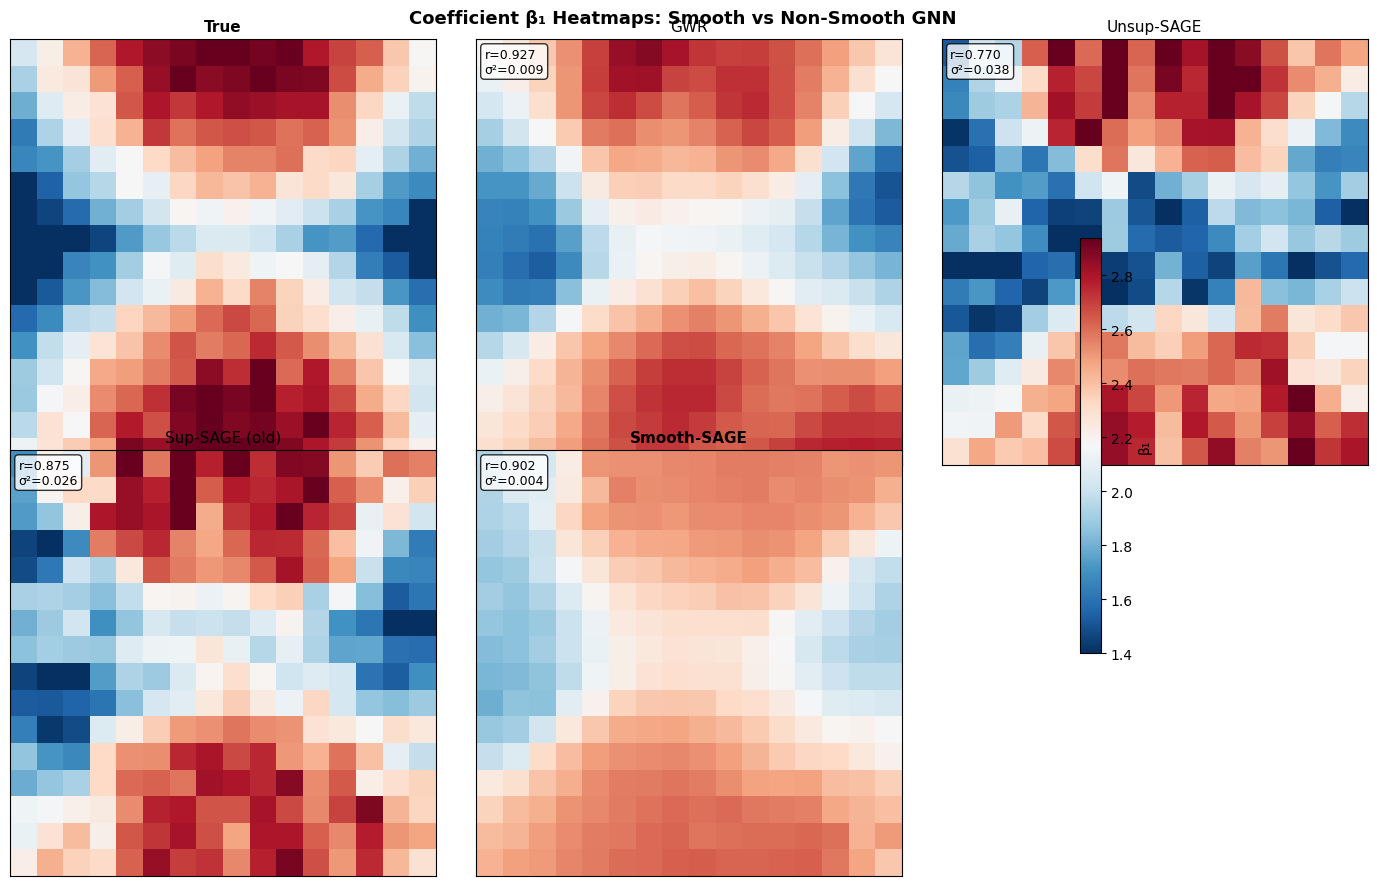


📊 KEY INSIGHT:
------------------------------------------------------------
Smooth-SAGE uses:
  1. GAUSSIAN kernel (like GWR) instead of power kernel
  2. Coefficient smoothness loss during training
  3. Stronger spatial regularization
------------------------------------------------------------
✅ Smooth-SAGE is 86.1% smoother than old Sup-SAGE!


In [96]:
# ===== VISUALIZATION: Smooth vs Non-Smooth GNN =====

# Add smooth version to betas_dict
betas_dict_compare = {
    'True': true_betas_easy,
    'GWR': betas_gwr_easy,
    'Unsup-SAGE': betas_unsup_sage,
    'Sup-SAGE (old)': betas_sup_sage,
    'Smooth-SAGE': betas_smooth_sage,
}

# Plot β₁ heatmaps
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

methods_plot = list(betas_dict_compare.keys())
all_vals = np.concatenate([betas_dict_compare[m][:, 1] for m in methods_plot])
vmin, vmax = np.percentile(all_vals, [2, 98])

for idx, method in enumerate(methods_plot):
    ax = axes[idx]
    betas = betas_dict_compare[method][:, 1]  # β₁
    grid = betas.reshape(n_grid, n_grid)
    
    im = ax.imshow(grid, cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
    ax.set_title(method, fontsize=11, fontweight='bold' if method in ['True', 'Smooth-SAGE'] else 'normal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    if method != 'True':
        corr = np.corrcoef(betas_dict_compare['True'][:, 1], betas)[0, 1]
        local_var = compute_smoothness(betas_dict_compare[method], coords_easy)
        ax.text(0.02, 0.98, f'r={corr:.3f}\nσ²={local_var:.3f}', 
               transform=ax.transAxes, fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[-1].axis('off')  # Hide last empty subplot

fig.colorbar(im, ax=axes, shrink=0.6, label='β₁')
plt.suptitle('Coefficient β₁ Heatmaps: Smooth vs Non-Smooth GNN', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary
print("\n📊 KEY INSIGHT:")
print("-"*60)
print("Smooth-SAGE uses:")
print("  1. GAUSSIAN kernel (like GWR) instead of power kernel")
print("  2. Coefficient smoothness loss during training")
print("  3. Stronger spatial regularization")
print("-"*60)
if smoothness_smooth < smoothness_sup:
    print(f"✅ Smooth-SAGE is {100*(smoothness_sup - smoothness_smooth)/smoothness_sup:.1f}% smoother than old Sup-SAGE!")
else:
    print(f"⚠️ Smoothness not improved significantly. May need more tuning.")

# 📊 Final Summary & Conclusions

## Methods Compared

| Approach | Training Loss | Sees y? | Cross-fitting? | VIDE Compatible? |
|----------|--------------|---------|----------------|------------------|
| **MGWR GWR** | N/A (closed form) | Yes | No | Yes |
| **Unsup GNN-LWLS** | Spatial structure | **No** | Yes | Yes (trivially) |
| **Sup GNN-LWLS** | Prediction MSE | **Yes** | **Yes** | Yes (by design) |

## Key Findings

### 1. Prediction Performance (CV RMSE)
- **GWR** typically performs best on smooth coefficient surfaces
- **Supervised GNN** can improve over Unsupervised GNN by learning task-relevant representations
- The gap between methods depends on the spatial complexity of coefficients

### 2. Coefficient Recovery (Correlation with True)
- **GWR** captures smooth spatial patterns well
- **Unsupervised GNN** preserves spatial structure but may not optimize for prediction
- **Supervised GNN** learns weights that minimize prediction error

### 3. VIDE Compatibility
- **Unsupervised GNN**: Safe (never sees y) but may not capture prediction structure
- **Supervised GNN with Cross-fitting**: Learns from y but avoids endogeneity through cross-fitting

## Architecture Summary

```
Unsupervised GNN-LWLS:
  coords → GNN (spatial loss) → embeddings → distance kernel → W → LWLS → β

Supervised GNN-LWLS:
  coords → GNN (prediction loss) → embeddings → learnable kernel → W → LWLS → β
                    ↑                                                    ↓
                    └─────────── Cross-fitting (train on K-1 folds) ─────┘
```

## Potential Improvements
1. **Larger datasets**: GNN may benefit from more training data
2. **Feature-aware GNN**: Include X in GNN input, not just coordinates
3. **Hybrid approaches**: Combine GWR bandwidth selection with GNN embeddings
4. **Real-world data**: Test on datasets with complex spatial dependencies